# Project_2_Hack_a_Boss


---



# Index

1. - [Definición del problema](#definicion-del-problema)
2. - [Recopilación de datos](#recopilacion-de-datos)
3. - [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
4. - [Procesamiento de Datos](#procesamiento-de-datos)
5. - [Modelo de Machine Learning](#modelo-de-machine-learning)
6. - [Desempeño del modelo (métricas)](#desempeno-del-modelo-metricas)
7. - [Métodos de Validación](#metodos-de-validacion) (Notebook 11)
8. - [Tuning](#tuning)
9. - [Resultados y Conclusiones](#resultados-y-conclusiones)

# 0. Libraries install & import

In [1]:
!pip install rdkit #rdkit need to be installed first

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 10.7 MB/s eta 0:00:00


In [2]:
#Installation MolVS
!pip install -q molvs #for data processing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 735.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
#Installation Lazyprecict
!pip install lazypredict


Librarys

In [93]:
# Data manipulation and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# RDKit for cheminformatics
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.rdmolops import GetFormalCharge, RemoveStereochemistry

# MOLVS for molecule standardization
from molvs.standardize import Standardizer
from molvs.charge import Uncharger, Reionizer
from molvs.fragment import LargestFragmentChooser
from molvs.tautomer import TautomerCanonicalizer

# Scipy for statistics and clustering
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import pearsonr

# Scikit-learn for machine learning and clustering
from sklearn import datasets
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression, Perceptron
from sklearn.metrics import accuracy_score, calinski_harabasz_score, davies_bouldin_score, mean_absolute_error, mean_squared_error, r2_score, silhouette_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor

# LazyPredict for automated model fitting
from lazypredict.Supervised import LazyRegressor

# Keras for deep learning
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Dropout, Embedding, Flatten, GlobalMaxPool1D, MaxPooling1D
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# TensorFlow for deep learning (if needed, TensorFlow Keras layers)
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv1D, Dense, Embedding, Flatten, GlobalMaxPool1D, MaxPooling1D, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Dataset
from sklearn.datasets import load_iris

# Métricas
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# 1.  Problem Definition <a name="definicion-del-problema"></a>

The data in this database have been obtained from molecular docking scoring. Molecular docking is a computational technique used in structural biology and drug design to predict the interaction between a protein and a ligand, evaluating the affinity and stability of this binding through a scoring function. This project focuses on using Machine Learning techniques to analyze and predict the results of molecular docking, aiming to identify potential protease inhibitors in a protein-ligand system.

The goal is to develop Machine Learning models that can accurately predict the docking scores, thereby reducing the computational cost of these simulations. This will allow for faster and more efficient evaluation of potential protease inhibitors.



# 2. Data collection <a name="recopilacion-de-datos"></a>

# 2.1 Data import and exploration

La base de datos se encuentra alojada en:

https://www.dropbox.com/scl/fi/1r28pp4elmjtlqid3beag/Database.xlsx?rlkey=pmhakgb4hkhpf8d6oprl1kqxp&dl=1

In [5]:
# extraer el database de Dropbox
# URL
file_url = 'https://www.dropbox.com/scl/fi/1r28pp4elmjtlqid3beag/Database.xlsx?rlkey=pmhakgb4hkhpf8d6oprl1kqxp&dl=1'

# Read the database using pd
database = pd.read_excel(file_url)


Exploring the data

In [6]:
print(database.head())


   Derivative                                             SMILES  min deltaG 
0           0  Oc1ccc(/C=C/C(=O)CC(=O)\C=C\c2ccc(O)c(OC)c2)cc1OC        -8.92
1           1    Oc1ccc(/C=C/C(O)CC(O)\C=C\c2ccc(O)c(OC)c2)cc1OC        -8.52
2           2   Oc1ccc(/C=C/C(=O)CC(O)\C=C\c2ccc(O)c(OC)c2)cc1OC        -8.48
3           3        Oc1ccc(CCC(=O)CC(=O)CCc2ccc(O)c(OC)c2)cc1OC        -8.93
4           4     Oc1ccc(CCC(=O)CC(=O)\C=C\c2ccc(O)c(OC)c2)cc1OC        -8.94


In [7]:
print(database.tail())

     Derivative                                             SMILES  \
301         301  OP(=O)(O)OCC(\C=C\C=C\C(=O)CC(=O)\C=C\C=C\C(CO...   
302         302  OP(=O)(O)OCC(OCOC)/C=C/C=C/C(=O)CC(=O)\C=C\C=C...   
303         303  CS(=O)(=O)NCC(OCOC)/C=C/C=C/C(=O)CC(=O)\C=C\C=...   
304         304  CS(=O)(=O)NCC(OCOC)/C=C/C=C/C(=O)CC(=O)\C=C\C=...   
305         305  O=S(=O)(O)OCC(\C=C\C=C\C(=O)CC(=O)\C=C\C=C\C(C...   

     min deltaG   
301       -10.69  
302        -9.61  
303        -9.39  
304        -9.70  
305       -10.59  


The 'Derivative' column shows the number of the molecule in the list, 'SMILES' columns shows the SMILES code of the structure and 'min delta G' column the values of the docking simulation with the 5IVS protein.

In [8]:
print(len(database))

306


## 2.2 Cleaning the database

In [9]:
#Functions definitions
STD = Standardizer() # Get the standardized version of a given SMILES string (canonical SMILES).
LFC = LargestFragmentChooser() # Select the largest fragment from a salt (ionic compound).
UC = Uncharger() # Charge corrections are applied to ensure, for example, that free metals are correctly ionized.
RI = Reionizer() # Neutralize molecule by adding/removing hydrogens.
TC = TautomerCanonicalizer()  # Return a tautormer “reasonable” from a chemist’s point, but isn’t guaranteed to be the most energetically favourable.

In [10]:
#Create a function to clean the data
def pretreatment(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol == None:
            #If rdkit could not parse the smiles, returns Error 1
            return "Error 1"
        else:
            mol = STD(mol)
            mol = LFC(mol)

            allowed_elements = {"H","B","C","N","O","F","Si","P","S","Cl","Se","Br","I"}
            actual_elements = set([atom.GetSymbol() for atom in mol.GetAtoms()])
            if len(actual_elements-allowed_elements) == 0:
                mol = UC(mol)
                mol = RI(mol)
                RemoveStereochemistry(mol)
                mol = TC(mol)
                return Chem.MolToSmiles(mol)
            else:
                # If molecule contains other than the allowed elements, return "Error 2"
                return "Error 2"
    except:
        return "Something else was found"

Apply the function

In [11]:
database["curated_SMILES"] = database['SMILES'].apply(pretreatment) #it may take a while >2min

Remove duplicates

In [12]:
database = database.drop_duplicates(subset=['curated_SMILES']).reset_index(drop=True)

In [13]:
print(len(database))

295


In [14]:
database = pd.DataFrame(database) #ensure that the database "database" still in a dataframe format

Save and download the cleaned data base as csv file

In [15]:

from google.colab import files
database.to_csv('cleaned_database.csv', index=False)
files.download('cleaned_database.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
database.head()

Derivative                                             SMILES  min deltaG   \
0           0  Oc1ccc(/C=C/C(=O)CC(=O)\C=C\c2ccc(O)c(OC)c2)cc1OC        -8.92   
1           1    Oc1ccc(/C=C/C(O)CC(O)\C=C\c2ccc(O)c(OC)c2)cc1OC        -8.52   
2           2   Oc1ccc(/C=C/C(=O)CC(O)\C=C\c2ccc(O)c(OC)c2)cc1OC        -8.48   
3           3        Oc1ccc(CCC(=O)CC(=O)CCc2ccc(O)c(OC)c2)cc1OC        -8.93   
4           4     Oc1ccc(CCC(=O)CC(=O)\C=C\c2ccc(O)c(OC)c2)cc1OC        -8.94   

                                  curated_SMILES  
0  COc1cc(C=CC(=O)CC(=O)C=Cc2ccc(O)c(OC)c2)ccc1O  
1    COc1cc(C=CC(O)CC(O)C=Cc2ccc(O)c(OC)c2)ccc1O  
2   COc1cc(C=CC(=O)CC(O)C=Cc2ccc(O)c(OC)c2)ccc1O  
3    COc1cc(CCC(=O)CC(=O)CCc2ccc(O)c(OC)c2)ccc1O  
4   COc1cc(C=CC(=O)CC(=O)CCc2ccc(O)c(OC)c2)ccc1O

## 2.3 Molecular descriptors

Generate the molecular descriptors using the library 'rdkit'.

With the SMILES data extracted, the SMILES were transformed into RDKit molecules.

In [17]:
molecules = [Chem.MolFromSmiles(smile) for smile in database["curated_SMILES"]]

Create the molecular descriptors for each molecule

In [18]:
smiles_list = database['curated_SMILES'].tolist()
delta_G = database['min deltaG '].tolist()

descriptor_names = [desc[0] for desc in Descriptors.descList] #extract the name of the column (the name of every descriptor)
df = pd.DataFrame(columns=['SMILES','delta_G'] + descriptor_names) #create a dataframe to save the molecular descriptors

for i, mol in enumerate(molecules):
    smiles = smiles_list[i]
    delta_g_value = delta_G[i]
    if mol is not None:
        descriptor_values = [desc[1](mol) for desc in Descriptors.descList]
        df.loc[len(df)] = [smiles, delta_g_value] + descriptor_values #create the data frame

[21:03:58] DEPRECATION WARNING: please use MorganGenerator
[21:03:58] DEPRECATION WARNING: please use MorganGenerator
[21:03:58] DEPRECATION WARNING: please use MorganGenerator
[21:03:58] DEPRECATION WARNING: please use MorganGenerator
[21:03:58] DEPRECATION WARNING: please use MorganGenerator
[21:03:58] DEPRECATION WARNING: please use MorganGenerator
[21:03:58] DEPRECATION WARNING: please use MorganGenerator
[21:03:58] DEPRECATION WARNING: please use MorganGenerator
[21:03:58] DEPRECATION WARNING: please use MorganGenerator
[21:03:58] DEPRECATION WARNING: please use MorganGenerator
[21:03:58] DEPRECATION WARNING: please use MorganGenerator
[21:03:58] DEPRECATION WARNING: please use MorganGenerator
[21:03:58] DEPRECATION WARNING: please use MorganGenerator
[21:03:58] DEPRECATION WARNING: please use MorganGenerator
[21:03:58] DEPRECATION WARNING: please use MorganGenerator
[21:03:58] DEPRECATION WARNING: please use MorganGenerator
[21:03:58] DEPRECATION WARNING: please use MorganGenerat

In [19]:
print(df.head())

                                          SMILES  delta_G  MaxAbsEStateIndex  \
0  COc1cc(C=CC(=O)CC(=O)C=Cc2ccc(O)c(OC)c2)ccc1O    -8.92              11.93   
1    COc1cc(C=CC(O)CC(O)C=Cc2ccc(O)c(OC)c2)ccc1O    -8.52              10.06   
2   COc1cc(C=CC(=O)CC(O)C=Cc2ccc(O)c(OC)c2)ccc1O    -8.48              11.99   
3    COc1cc(CCC(=O)CC(=O)CCc2ccc(O)c(OC)c2)ccc1O    -8.93              12.05   
4   COc1cc(C=CC(=O)CC(=O)CCc2ccc(O)c(OC)c2)ccc1O    -8.94              12.02   

   MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  qed   SPS  MolWt  \
0           11.93               0.01           -0.35 0.55 11.04 368.39   
1           10.06               0.04           -0.85 0.57 13.78 372.42   
2           11.99               0.02           -0.95 0.62 12.41 370.40   
3           12.05               0.05           -0.12 0.62 10.44 372.42   
4           12.02               0.02           -0.30 0.52 10.74 370.40   

   HeavyAtomMolWt  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
0         

In [20]:
print(df.tail())

                                                SMILES  delta_G  \
290  COCOC(=CC=CCC(=O)CC(=O)C=CC=CC(CN)CO[PH](=O)(=...   -10.69   
291  COCOC(=CC=CCC(=O)CC(=O)C=CC=CC(C)CN)CO[PH](=O)...    -9.61   
292  COCOC(=CC=CCC(=O)CC(=O)C=CC=CC(CN)CNS(C)(=O)=O...    -9.39   
293   COCOC(=CC=CCC(=O)CC(=O)C=CC=CC(C)CN)CNS(C)(=O)=O    -9.70   
294  COCOC(=CC=CCC(=O)CC(=O)C=CC=CC(CN)CO[PH](=O)(=...   -10.59   

     MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
290              11.85           11.85               0.02           -5.21   
291              11.77           11.77               0.01           -5.16   
292              11.92           11.92               0.01           -3.40   
293              11.81           11.81               0.04           -3.36   
294              11.85           11.85               0.00           -5.12   

     qed   SPS  MolWt  HeavyAtomMolWt  ...  fr_sulfide  fr_sulfonamd  \
290 0.06 14.36 513.37          484.14  ...           0        

In [21]:
df.SMILES.apply(len).min() #comprobar el valor mínimo de la columna SMILES

33

In [22]:
num_rows = df.shape[0]
num_columns = df.shape[1]

info = f"The DataFrame created has {num_rows} rows and {num_columns} columns."
print(info)

The DataFrame created has 295 rows and 212 columns.


In [23]:
"""
#para imprimir el nombre de todas las columnas
# print all the columns names (all the molecular descriptors name)
column_names = df.columns.tolist()
for name in column_names:
  print(name)
"""

'\n#para imprimir el nombre de todas las columnas\n# print all the columns names (all the molecular descriptors name)\ncolumn_names = df.columns.tolist()\nfor name in column_names:\n  print(name)\n'

### Names of molecular descriptors grouped by type

EState Descriptors

    MaxAbsEStateIndex
    MaxEStateIndex
    MinAbsEStateIndex
    MinEStateIndex

Molecular Properties

    qed
    SPS
    MolWt
    HeavyAtomMolWt
    ExactMolWt
    NumValenceElectrons
    NumRadicalElectrons

Partial Charges

    MaxPartialCharge
    MinPartialCharge
    MaxAbsPartialCharge
    MinAbsPartialCharge

Fingerprints

    FpDensityMorgan1
    FpDensityMorgan2
    FpDensityMorgan3

BCUT Descriptors

    BCUT2D_MWHI
    BCUT2D_MWLOW
    BCUT2D_CHGHI
    BCUT2D_CHGLO
    BCUT2D_LOGPHI
    BCUT2D_LOGPLOW
    BCUT2D_MRHI
    BCUT2D_MRLOW

Topological Descriptors

    AvgIpc
    BalabanJ
    BertzCT
    Chi0
    Chi0n
    Chi0v
    Chi1
    Chi1n
    Chi1v
    Chi2n
    Chi2v
    Chi3n
    Chi3v
    Chi4n
    Chi4v

Shape Descriptors

    HallKierAlpha
    Ipc
    Kappa1
    Kappa2
    Kappa3
    LabuteASA

PEOE VSA Descriptors

    PEOE_VSA1
    PEOE_VSA10
    PEOE_VSA11
    PEOE_VSA12
    PEOE_VSA13
    PEOE_VSA14
    PEOE_VSA2
    PEOE_VSA3
    PEOE_VSA4
    PEOE_VSA5
    PEOE_VSA6
    PEOE_VSA7
    PEOE_VSA8
    PEOE_VSA9

SMR VSA Descriptors

    SMR_VSA1
    SMR_VSA10
    SMR_VSA2
    SMR_VSA3
    SMR_VSA4
    SMR_VSA5
    SMR_VSA6
    SMR_VSA7
    SMR_VSA8
    SMR_VSA9

SlogP VSA Descriptors

    SlogP_VSA1
    SlogP_VSA10
    SlogP_VSA11
    SlogP_VSA12
    SlogP_VSA2
    SlogP_VSA3
    SlogP_VSA4
    SlogP_VSA5
    SlogP_VSA6
    SlogP_VSA7
    SlogP_VSA8
    SlogP_VSA9

TPSA

    TPSA

EState VSA Descriptors

    EState_VSA1
    EState_VSA10
    EState_VSA11
    EState_VSA2
    EState_VSA3
    EState_VSA4
    EState_VSA5
    EState_VSA6
    EState_VSA7
    EState_VSA8
    EState_VSA9

VSA EState Descriptors

    VSA_EState1
    VSA_EState10
    VSA_EState2
    VSA_EState3
    VSA_EState4
    VSA_EState5
    VSA_EState6
    VSA_EState7
    VSA_EState8
    VSA_EState9

Simple Molecular Properties

    FractionCSP3
    HeavyAtomCount
    NHOHCount
    NOCount
    NumAliphaticCarbocycles
    NumAliphaticHeterocycles
    NumAliphaticRings
    NumAromaticCarbocycles
    NumAromaticHeterocycles
    NumAromaticRings
    NumHAcceptors
    NumHDonors
    NumHeteroatoms
    NumRotatableBonds
    NumSaturatedCarbocycles
    NumSaturatedHeterocycles
    NumSaturatedRings
    RingCount
    MolLogP
    MolMR

Functional Group Descriptors

    fr_Al_COO
    fr_Al_OH
    fr_Al_OH_noTert
    fr_ArN
    fr_Ar_COO
    fr_Ar_N
    fr_Ar_NH
    fr_Ar_OH
    fr_COO
    fr_COO2
    fr_C_O
    fr_C_O_noCOO
    fr_C_S
    fr_HOCCN
    fr_Imine
    fr_NH0
    fr_NH1
    fr_NH2
    fr_N_O
    fr_Ndealkylation1
    fr_Ndealkylation2
    fr_Nhpyrrole
    fr_SH
    fr_aldehyde
    fr_alkyl_carbamate
    fr_alkyl_halide
    fr_allylic_oxid
    fr_amide
    fr_amidine
    fr_aniline
    fr_aryl_methyl
    fr_azide
    fr_azo
    fr_barbitur
    fr_benzene
    fr_benzodiazepine
    fr_bicyclic
    fr_diazo
    fr_dihydropyridine
    fr_epoxide
    fr_ester
    fr_ether
    fr_furan
    fr_guanido
    fr_halogen
    fr_hdrzine
    fr_hdrzone
    fr_imidazole
    fr_imide
    fr_isocyan
    fr_isothiocyan
    fr_ketone
    fr_ketone_Topliss
    fr_lactam
    fr_lactone
    fr_methoxy
    fr_morpholine
    fr_nitrile
    fr_nitro
    fr_nitro_arom
    fr_nitro_arom_nonortho
    fr_nitroso
    fr_oxazole
    fr_oxime
    fr_para_hydroxylation
    fr_phenol
    fr_phenol_noOrthoHbond
    fr_phos_acid
    fr_phos_ester
    fr_piperdine
    fr_piperzine
    fr_priamide
    fr_prisulfonamd
    fr_pyridine
    fr_quatN
    fr_sulfide
    fr_sulfonamd
    fr_sulfone
    fr_term_acetylene
    fr_tetrazole
    fr_thiazole
    fr_thiocyan
    fr_thiophene
    fr_unbrch_alkane
    fr_urea

1. EState Descriptors

Los descriptores de estado electrónico (EState) proporcionan información sobre la distribución de la densidad electrónica en una molécula. Se basan en la estructura de la molécula y la electronegatividad de los átomos involucrados. Los descriptores como MaxAbsEStateIndex y MinEStateIndex ayudan a entender las regiones más y menos electrostáticas de la molécula.
2. Molecular Properties

Estos descriptores cuantifican propiedades físicas y químicas básicas de las moléculas. Incluyen el peso molecular (MolWt, ExactMolWt), el número de electrones de valencia (NumValenceElectrons), y la fracción de anillos saturados o insaturados. Son esenciales para determinar características fundamentales de una molécula.
3. Partial Charges

Los descriptores de carga parcial miden la distribución de la carga eléctrica en la molécula. Descriptores como MaxPartialCharge y MinAbsPartialCharge indican las cargas parciales más positivas y más negativas, proporcionando información sobre la polaridad y la reactividad potencial de la molécula.
4. Fingerprints

Los fingerprints son representaciones digitales de las moléculas que capturan la presencia o ausencia de ciertos subestructuras o características. FpDensityMorgan1, FpDensityMorgan2 y FpDensityMorgan3 son ejemplos de estos descriptores basados en subestructuras moleculares y ayudan en la comparación y búsqueda de moléculas similares.
5. BCUT Descriptors

Los descriptores BCUT (Burden-CAS University of Texas) son una combinación de propiedades atómicas y topológicas. Descriptores como BCUT2D_MWHI y BCUT2D_LOGPHI proporcionan información sobre la distribución de diferentes propiedades (como el peso molecular y el logP) en una molécula.
6. Topological Descriptors

Estos descriptores cuantifican aspectos de la estructura topológica de la molécula. Incluyen descriptores como BalabanJ, BertzCT y varios índices de conectividad Chi. Ayudan a entender la complejidad y la forma de la molécula basada en su estructura de enlaces y átomos.
7. Shape Descriptors

Los descriptores de forma capturan información sobre la forma tridimensional de la molécula. Descriptores como HallKierAlpha y Kappa1 proporcionan una medida de la ramificación y el volumen molecular, lo cual es crucial para entender la interacción de la molécula con otras entidades.
8. PEOE VSA Descriptors

Los descriptores de área de superficie accesible de carga parcial (PEOE VSA) miden la distribución de la carga parcial en la superficie de la molécula. PEOE_VSA1 a PEOE_VSA14 capturan diferentes aspectos de esta distribución y son útiles para predecir propiedades como la solubilidad y la reactividad.
9. SMR VSA Descriptors

Los descriptores de área de superficie accesible del índice de refracción molar (SMR VSA) cuantifican cómo el volumen molecular y la superficie se relacionan con el índice de refracción. SMR_VSA1 a SMR_VSA10 proporcionan diferentes perspectivas sobre esta relación.
10. SlogP VSA Descriptors

Los descriptores de área de superficie accesible del logaritmo del coeficiente de partición octanol/agua (SlogP VSA) cuantifican cómo la superficie de la molécula influye en su lipofilicidad. SlogP_VSA1 a SlogP_VSA12 son utilizados para predecir la solubilidad y permeabilidad de la molécula.
11. TPSA

El área de superficie polar topológica (TPSA) es un descriptor que cuantifica el área de superficie de una molécula que es polar. Es útil para predecir la permeabilidad de las moléculas a través de las membranas celulares y su biodisponibilidad.
12. EState VSA Descriptors

Los descriptores de área de superficie accesible del estado electrónico (EState VSA) combinan información sobre la superficie molecular y la densidad electrónica. EState_VSA1 a EState_VSA11 proporcionan una perspectiva detallada de cómo la superficie y la electrónica interactúan en una molécula.
13. VSA EState Descriptors

Los descriptores de estado electrónico del área de superficie accesible (VSA EState) también combinan la superficie molecular con información electrónica, pero desde una perspectiva ligeramente diferente. VSA_EState1 a VSA_EState10 capturan estas interacciones de manera detallada.
14. Simple Molecular Properties

Estos descriptores cuantifican propiedades moleculares básicas y sencillas como el número de átomos pesados (HeavyAtomCount), el número de aceptores y donadores de hidrógeno (NumHAcceptors, NumHDonors), y el coeficiente de partición (MolLogP). Son fundamentales para la caracterización básica de una molécula.
15. Functional Group Descriptors

Los descriptores de grupos funcionales cuantifican la presencia de diferentes grupos funcionales en la molécula. Descriptores como fr_Al_COO, fr_Ar_OH y fr_Nitro proporcionan información sobre grupos específicos que pueden influir en la reactividad y propiedades de la molécula.

The dataframe created contains all the molecular descriptors, the SMILES and the binding energy.


# 3 Exploratory Data Analysis (EDA) <a name="exploratory-data-analysis-eda"></a>

It was created a dataframe with more than 200 moleculars descriptors, from them, it is necessary to choose wisely wich one could be optimal for the study.

In [24]:

# Selected descriptors list
selected_descriptors = [
    'MolWt', 'MolLogP', 'TPSA', 'NumHAcceptors', 'NumHDonors',
    'HeavyAtomCount', 'FractionCSP3', 'BalabanJ', 'BertzCT',
    'Kappa1', 'Kappa2', 'Kappa3', 'Chi0v', 'Chi1v', 'Chi2v',
    'LabuteASA', 'EState_VSA1', 'EState_VSA2', 'EState_VSA3',
    'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7',
    'EState_VSA8', 'EState_VSA9', 'EState_VSA10', 'EState_VSA11',
    'PEOE_VSA1', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5',
    'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'PEOE_VSA10',
    'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14',
    'NumRotatableBonds', 'RingCount'
]

#new dataframe with the selected descriptors
df_selected = df[['SMILES', 'delta_G'] + selected_descriptors]


NOTA: Silenciando lo anterior, la df es 295x212. la PCA utiliza 32 componentes principales para el 95% de la varianza
Utilizando las variables seleccionadas:

selected_descriptors = [
    'MolWt', 'MolLogP', 'TPSA', 'NumHAcceptors', 'NumHDonors',
    'HeavyAtomCount', 'FractionCSP3', 'BalabanJ', 'BertzCT',
    'Kappa1', 'Kappa2', 'Kappa3', 'Chi0v', 'Chi1v', 'Chi2v',
    'LabuteASA', 'EState_VSA1', 'EState_VSA2', 'EState_VSA3',
    'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7',
    'EState_VSA8', 'EState_VSA9', 'EState_VSA10', 'EState_VSA11',
    'PEOE_VSA1', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5',
    'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'PEOE_VSA10',
    'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14',
    'NumRotatableBonds', 'RingCount'
]

la df es 295x45 y la PCA queda en 18 para 95%

In [25]:
num_rows = df_selected.shape[0]
num_columns = df_selected.shape[1]

info = f"The DataFrame created has {num_rows} rows and {num_columns} columns."
print(info)

The DataFrame created has 295 rows and 45 columns.


In [26]:
df_selected.head()

SMILES  delta_G  MolWt  MolLogP  \
0  COc1cc(C=CC(=O)CC(=O)C=Cc2ccc(O)c(OC)c2)ccc1O    -8.92 368.39     3.37   
1    COc1cc(C=CC(O)CC(O)C=Cc2ccc(O)c(OC)c2)ccc1O    -8.52 372.42     2.95   
2   COc1cc(C=CC(=O)CC(O)C=Cc2ccc(O)c(OC)c2)ccc1O    -8.48 370.40     3.16   
3    COc1cc(CCC(=O)CC(=O)CCc2ccc(O)c(OC)c2)ccc1O    -8.93 372.42     3.21   
4   COc1cc(C=CC(=O)CC(=O)CCc2ccc(O)c(OC)c2)ccc1O    -8.94 370.40     3.29   

   TPSA  NumHAcceptors  NumHDonors  HeavyAtomCount  FractionCSP3  BalabanJ  \
0 93.06              6           2              27          0.14      1.96   
1 99.38              6           4              27          0.24      1.94   
2 96.22              6           3              27          0.19      1.95   
3 93.06              6           2              27          0.33      1.79   
4 93.06              6           2              27          0.24      1.87   

   ...  PEOE_VSA7  PEOE_VSA8  PEOE_VSA9  PEOE_VSA10  PEOE_VSA11  PEOE_VSA12  \
0  ...      47.54       0.00      20.64        0.00       34.56        0.00   
1  ...      35.39       6.42      26.43        0.00       23.00        0.00   
2  ...      41.47       6.42      20.32        0.00       28.78        0.00   
3  ...      48.23      12.84      20.64       11.57       23.00        0.00   
4  ...      47.89       6.42      20.64        5.78       28.78        0.00   

   PEOE_VSA13  PEOE_VSA14  NumRotatableBonds  RingCount  
0        0.00        0.00                  8          2  
1        0.00        0.00                  8          2  
2        0.00        0.00                  8          2  
3        0.00        0.00                 10          2  
4        0.00        0.00                  9          2  

[5 rows x 45 columns]

Basic statistics about the dataframe

In [27]:
df_selected.describe()

delta_G  MolWt  MolLogP   TPSA  NumHAcceptors  NumHDonors  \
count   295.00 295.00   295.00 295.00         295.00      295.00   
mean     -9.55 491.29     5.36  95.62           5.44        2.25   
std       0.81  94.45     2.32  41.74           2.00        1.96   
min     -12.06 276.33    -0.87   0.00           0.00        0.00   
25%     -10.01 426.51     3.55  71.44           4.00        1.00   
50%      -9.42 484.53     5.42  86.74           6.00        2.00   
75%      -8.99 546.63     6.88 109.85           6.00        4.00   
max      -7.57 817.04    10.93 232.12          12.00       10.00   

       HeavyAtomCount  FractionCSP3  BalabanJ  BertzCT  ...  PEOE_VSA7  \
count          295.00        295.00    295.00   295.00  ...     295.00   
mean            35.05          0.43      2.04  1020.16  ...      68.05   
std              6.47          0.23      0.92   353.10  ...      27.91   
min             21.00          0.03      1.22   300.93  ...      11.13   
25%             31.00          0.24      1.51   783.56  ...      48.39   
50%             35.00          0.36      1.80   918.64  ...      70.80   
75%             39.00          0.67      2.15  1238.48  ...      87.08   
max             57.00          1.00      5.55  2033.19  ...     134.60   

       PEOE_VSA8  PEOE_VSA9  PEOE_VSA10  PEOE_VSA11  PEOE_VSA12  PEOE_VSA13  \
count     295.00     295.00      295.00      295.00      295.00      295.00   
mean       21.87      15.74        8.83       10.28        3.01        1.44   
std        13.56       8.52        6.56        8.33        5.39        3.72   
min         0.00       0.00        0.00        0.00        0.00        0.00   
25%        11.37      11.13        5.75        5.78        0.00        0.00   
50%        22.50      13.21       11.50       11.57        0.00        0.00   
75%        31.68      19.63       11.57       11.57        6.43        0.00   
max        64.83      42.55       25.14       46.25       20.05       20.05   

       PEOE_VSA14  NumRotatableBonds  RingCount  
count      295.00             295.00     295.00  
mean         0.97              11.99       2.29  
std          3.32               3.28       0.99  
min          0.00               6.00       0.00  
25%          0.00               9.00       2.00  
50%          0.00              12.00       2.00  
75%          0.00              14.00       3.00  
max         17.87              21.00       4.00  

[8 rows x 44 columns]

Searching for Na's values

In [28]:
nan_counts = df_selected.isna().sum()
print(nan_counts)


SMILES               0
delta_G              0
MolWt                0
MolLogP              0
TPSA                 0
NumHAcceptors        0
NumHDonors           0
HeavyAtomCount       0
FractionCSP3         0
BalabanJ             0
BertzCT              0
Kappa1               0
Kappa2               0
Kappa3               0
Chi0v                0
Chi1v                0
Chi2v                0
LabuteASA            0
EState_VSA1          0
EState_VSA2          0
EState_VSA3          0
EState_VSA4          0
EState_VSA5          0
EState_VSA6          0
EState_VSA7          0
EState_VSA8          0
EState_VSA9          0
EState_VSA10         0
EState_VSA11         0
PEOE_VSA1            0
PEOE_VSA2            0
PEOE_VSA3            0
PEOE_VSA4            0
PEOE_VSA5            0
PEOE_VSA6            0
PEOE_VSA7            0
PEOE_VSA8            0
PEOE_VSA9            0
PEOE_VSA10           0
PEOE_VSA11           0
PEOE_VSA12           0
PEOE_VSA13           0
PEOE_VSA14           0
NumRotatabl

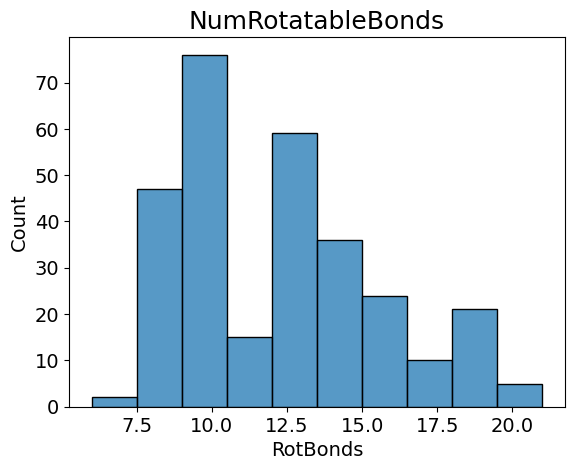

In [29]:
# Creat the histogram with Seaborn
hist = sns.histplot(x="NumRotatableBonds", data=df_selected)

# Title, axis titles, and font size
hist.set_title("NumRotatableBonds", fontsize=18)
hist.set_xlabel("RotBonds", fontsize=14)
hist.set_ylabel("Count", fontsize=14)
hist.tick_params(labelsize=14)

# Show the graph
plt.show()

## TO DO:
mejorar la gráfica. que muestre una columna por valor, 5,6,7...etc

This histogram provides a clear visualization of how the number of rotatable bonds is distributed in the molecule data set. it can be quickly see that most molecules have a number of rotatable bonds in the range of 7.5 to 20, and that there is a significant peak around 10 rotatable bonds. This can be useful for understanding the physical and chemical properties of the molecules in the study.

**Figura 1.** Diferentes elementos que componen un *boxplot*
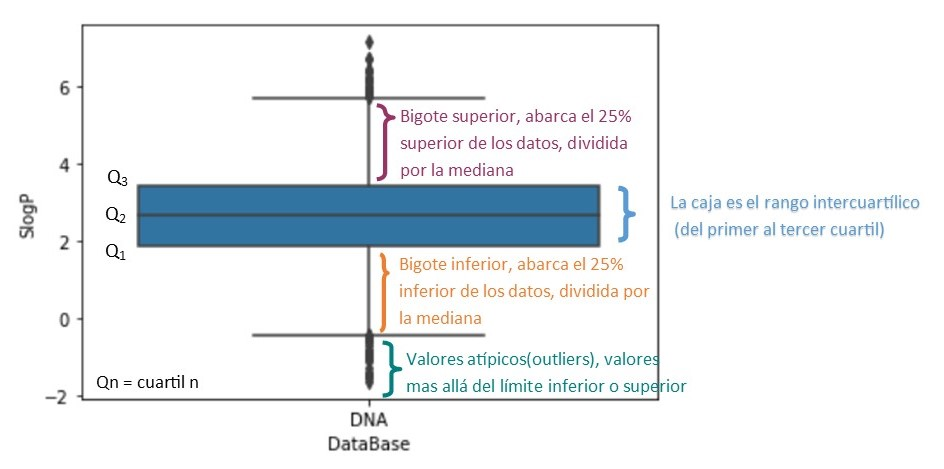

In [30]:
print(df_selected.columns)


Index(['SMILES', 'delta_G', 'MolWt', 'MolLogP', 'TPSA', 'NumHAcceptors',
       'NumHDonors', 'HeavyAtomCount', 'FractionCSP3', 'BalabanJ', 'BertzCT',
       'Kappa1', 'Kappa2', 'Kappa3', 'Chi0v', 'Chi1v', 'Chi2v', 'LabuteASA',
       'EState_VSA1', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4',
       'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8',
       'EState_VSA9', 'EState_VSA10', 'EState_VSA11', 'PEOE_VSA1', 'PEOE_VSA2',
       'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7',
       'PEOE_VSA8', 'PEOE_VSA9', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
       'PEOE_VSA13', 'PEOE_VSA14', 'NumRotatableBonds', 'RingCount'],
      dtype='object')


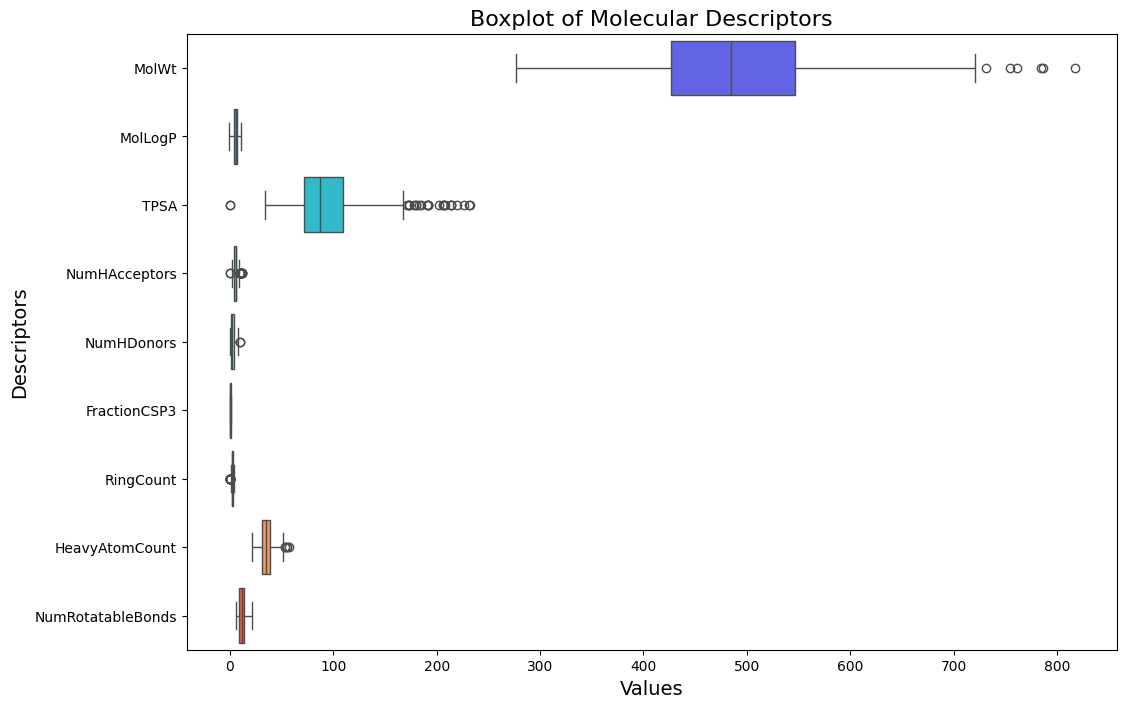

In [31]:
# Select the data
selected_descriptors_box = [
    'MolWt', 'MolLogP', 'TPSA', 'NumHAcceptors', 'NumHDonors',
    'FractionCSP3', 'RingCount', 'HeavyAtomCount', 'NumRotatableBonds'
]

# Create a DataFrame with the selected descriptors
df_selected_descriptors_box = df[selected_descriptors_box]

# Create horizontal boxplots for each descriptor
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=df_selected_descriptors_box, orient="h", palette="rainbow")

# Customize chart
plt.xlabel('Values', size=14)
plt.ylabel('Descriptors', size=14)
plt.title('Boxplot of Molecular Descriptors', size=16)

# Print the plot
plt.show()

The values are in different scales. Plot the same one with a logaritmit scala

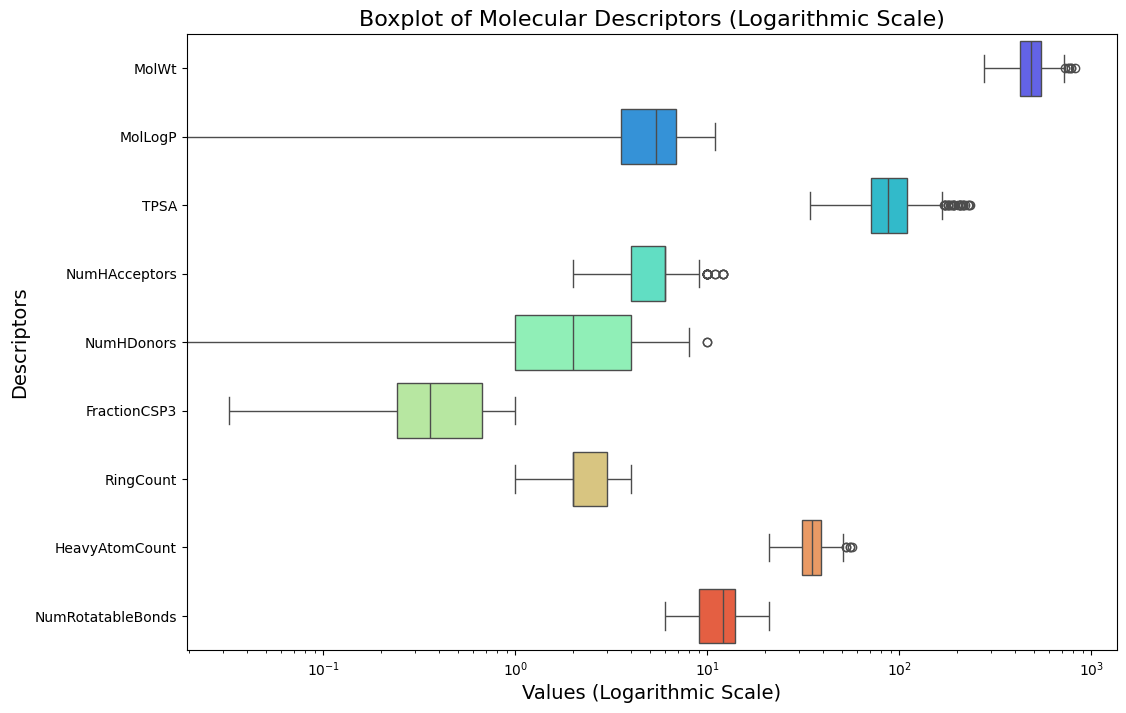

In [32]:
# Create horizontal boxplots for each descriptor
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=df_selected_descriptors_box, orient="h", palette="rainbow")

# Apply logarithmic scale to the X axis
ax.set_xscale('log')

#Customize chart
plt.xlabel('Values ​​(Logarithmic Scale)', size=14)
plt.ylabel('Descriptors', size=14)
plt.title('Boxplot of Molecular Descriptors (Logarithmic Scale)', size=16)

# Print the plot
plt.show()

MolWt:
The molecular weight has a wide distribution with some very high outliers.
The median is around 500.

MolLogP:
The partition coefficient has a more concentrated distribution with some outliers.

Topological Polar Surface Area:
TPSA has a concentrated distribution with some outliers.

Number of Hydrogen Bond Acceptors and Donors:
Both have similar distributions, with most values in the range of 1 to 10.
NumHDonors shows more variability and some outliers.

Fraction of SP3 Carbons:
The fraction of SP3 carbon atoms has a narrower distribution, primarily between 0.1 and 1.

Number of Rings:
The number of rings has a concentrated distribution between 1 and 10.

Number of Heavy Atoms:
The number of heavy atoms has a broad distribution, with most values between 10 and 100.

Number of Rotatable Bonds:
The distribution of rotatable bonds is concentrated at low values, with some outliers.

## Analysis

Variability: The logarithmic scale clearly shows the variability in the magnitude of the descriptors. For instance, MolWt and HeavyAtomCount have greater variability compared to other descriptors.

Outliers: Some descriptors have significant outliers, such as MolWt, TPSA, and NumRotatableBonds. This may indicate the presence of molecules with extreme properties in the dataset.

Distribution: Most descriptors have right-skewed distributions on the logarithmic scale, indicating that most values are small with a few large values.

## Conclusion

The use of the logarithmic scale provides a better understanding of the distribution and variability of molecular descriptors in the dataset. The presence of outliers and the variability in the descriptors are important aspects to consider in any further analysis, such as modeling or interpreting molecular properties.

The data means vary greatly. This occurs because the data is on differente scales, meaning that different units are used to measure different characterisitics. A proccess call normalize will be use

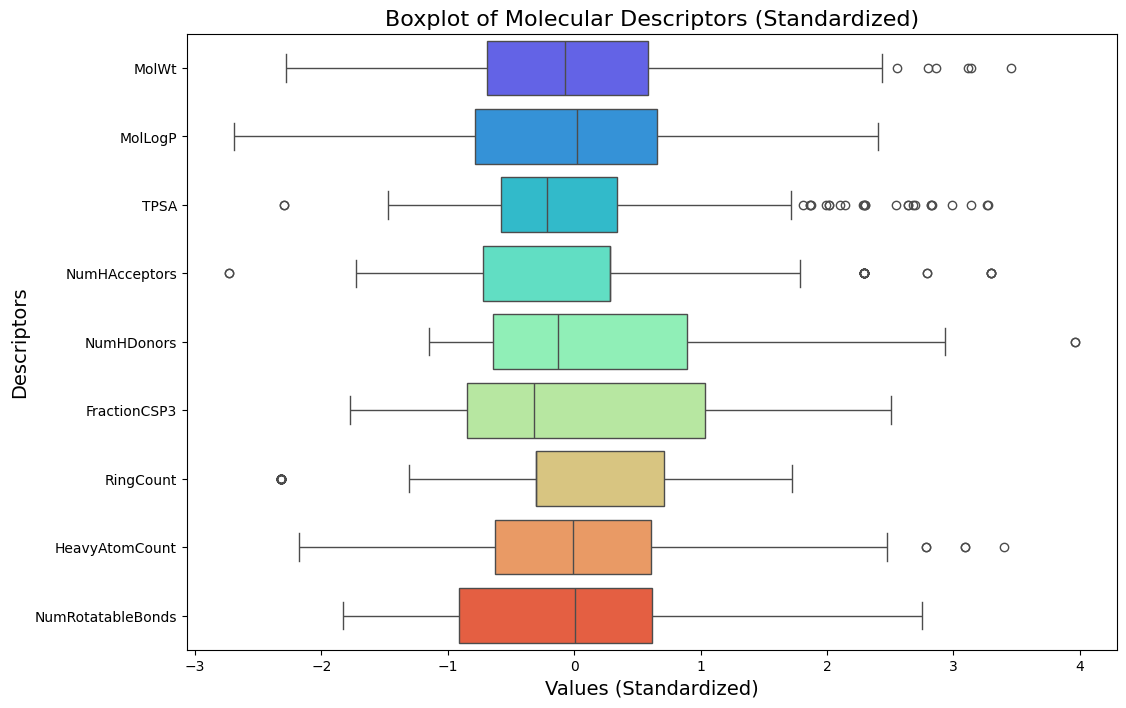

In [33]:
# Normalize the data using StandardScaler
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_selected_descriptors_box)
df_normalized = pd.DataFrame(df_normalized, columns=selected_descriptors_box)

# Create horizontal boxplots for each descriptor
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=df_normalized, orient="h", palette="rainbow")

# Customize the plot
plt.xlabel('Values (Standardized)', size=14)
plt.ylabel('Descriptors', size=14)
plt.title('Boxplot of Molecular Descriptors (Standardized)', size=16)

# Show the plot
plt.show()

# TO DO: Remove Outliers

## Variability:

Some descriptors, such as TPSA and NumHAcceptors, show greater variability with a wider interquartile range compared to other descriptors.
Variability is lower for descriptors such as FractionCSP3 and RingCount

#### About **Lipinkski's Rule** of five:

No more than 5 hydrogen bond donors (NumHDonors): Hydrogen bond donors are typically NH or OH groups.

No more than 10 hydrogen bond acceptors (NumHAcceptors): Hydrogen bond acceptors include nitrogen and oxygen atoms.

Molecular weight (MolWt) no greater than 500 daltons.

LogP no greater than 5: LogP is the logarithm of the compound's octanol-water partition coefficient.

**Figura 2.** Diferentes elementos que componen un *violinplot* <br>
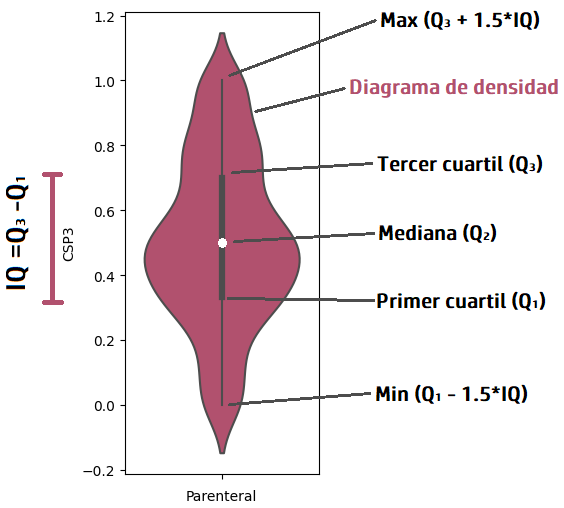

### Create violin plots:

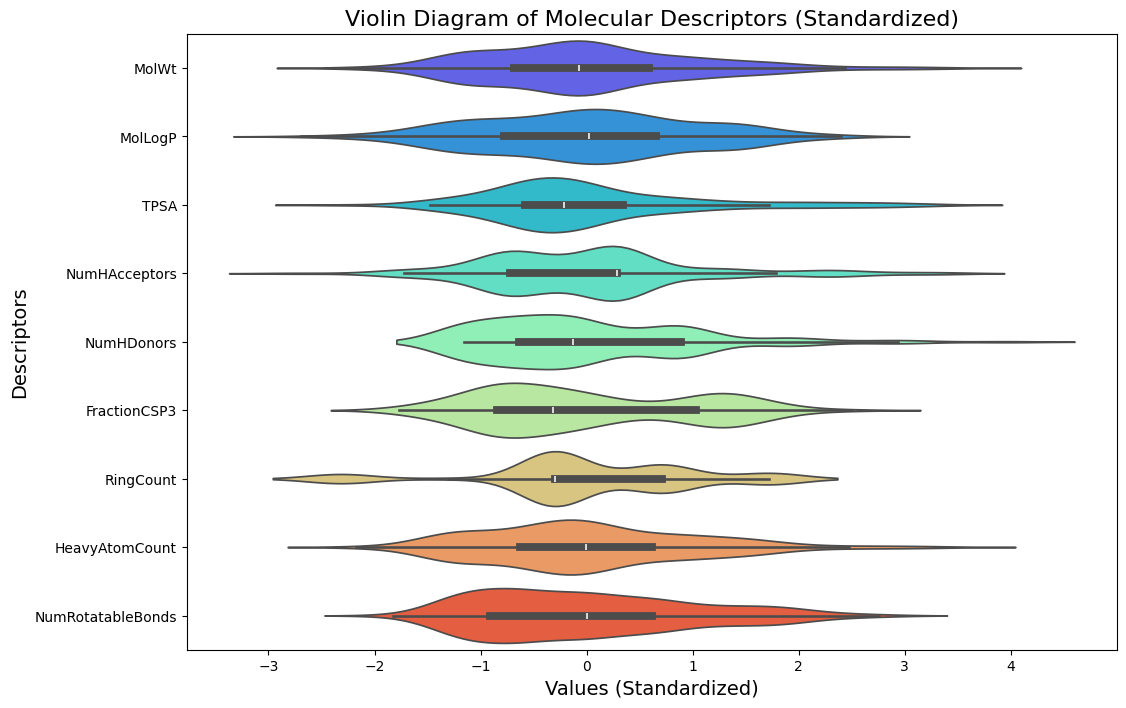

In [34]:
#Normalize data with StandardScaler
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_selected_descriptors_box)
df_normalized = pd.DataFrame(df_normalized, columns=selected_descriptors_box)

# Create horizontal violin plots for each descriptor
plt.figure(figsize=(12, 8))
ax = sns.violinplot(data=df_normalized, orient="h", palette="rainbow")

# Customize chart
plt.xlabel('Values ​​(Standardized)', size=14)
plt.ylabel('Descriptors', size=14)
plt.title('Violin Diagram of Molecular Descriptors (Standardized)', size=16)

# Print the plot
plt.show()


# Data frame with the selected descriptors for the EDA
df_selected_descriptors_box = df[selected_descriptors_box]

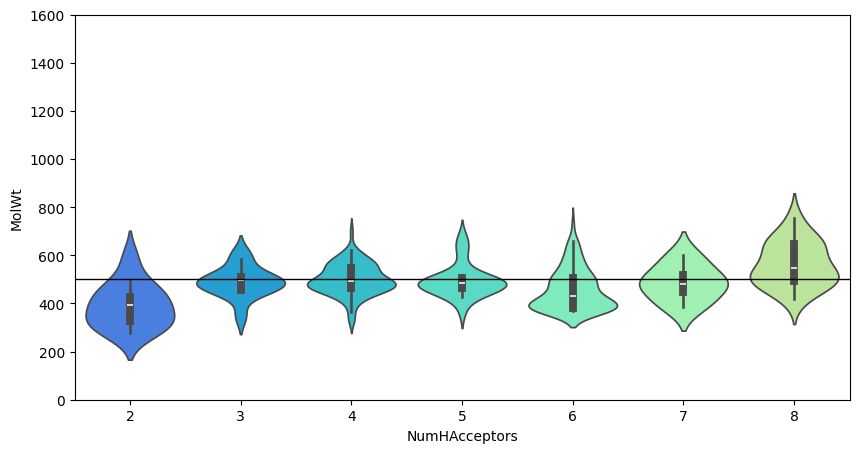

In [35]:
#Violinplot of number of NumHAcceptors vs. MolWt
ax = sns.violinplot(x = 'NumHAcceptors', y = 'MolWt', data = df_selected_descriptors_box, palette="rainbow")
#Set limits for both axes
ax.set_xlim(0.5, 7.5)
ax.set_ylim(0, 1600)
ax.axhline(y=500, color='black', linestyle='-', linewidth=1)
ax.axvline(x=10, color='black', linestyle='-', linewidth=1)
#Customize the size and print
plt.gcf().set_size_inches(10, 5)

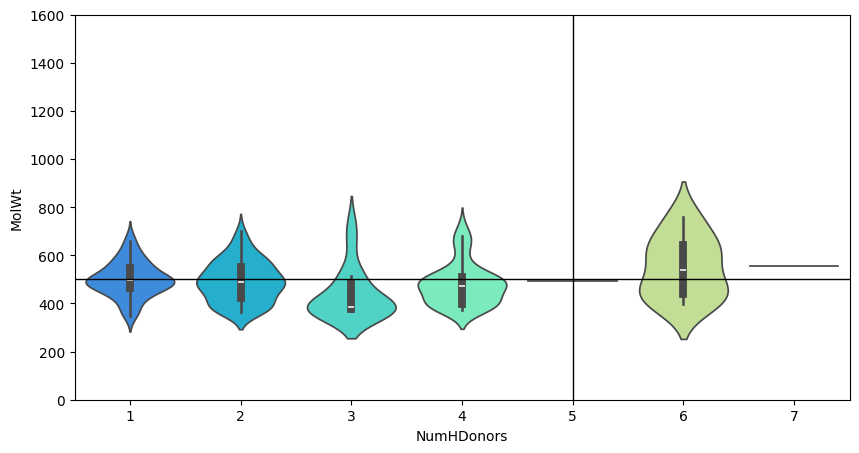

In [36]:
#Violinplot of number of rings vs. molar mass of oral drugs
ax = sns.violinplot(x = 'NumHDonors', y = 'MolWt', data = df_selected_descriptors_box, palette="rainbow")
#Set limits for both axes
ax.set_xlim(0.5, 7.5)
ax.set_ylim(0, 1600)
ax.axhline(y=500, color='black', linestyle='-', linewidth=1)
ax.axvline(x=5, color='black', linestyle='-', linewidth=1)
#Customize the size and print
plt.gcf().set_size_inches(10, 5)

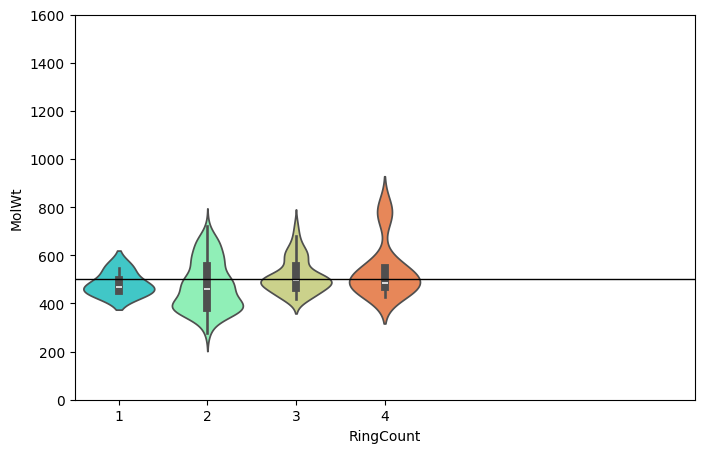

In [37]:
#Violinplot of number of rings vs. molar mass of oral drugs
ax = sns.violinplot(x = 'RingCount', y = 'MolWt', data = df_selected_descriptors_box, palette="rainbow")
#Set limits for both axes
ax.set_xlim(0.5, 7.5)
ax.set_ylim(0, 1600)

ax.axhline(y=500, color='black', linestyle='-', linewidth=1)
#Customize the size and print
plt.gcf().set_size_inches(8, 5)

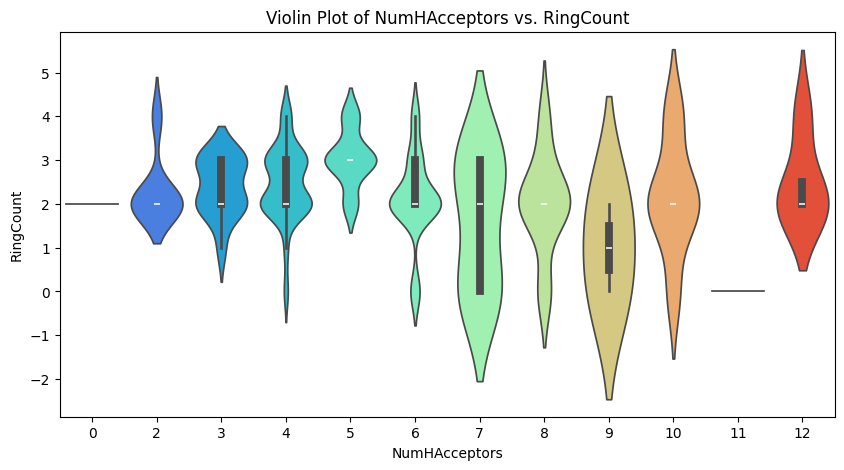

In [38]:
# Violin diagram for NumHAcceptors vs. RingCount
plt.figure(figsize=(10, 5))
ax = sns.violinplot(x='NumHAcceptors', y='RingCount', data= df_selected_descriptors_box, palette="rainbow")
plt.title('Violin Plot of NumHAcceptors vs. RingCount')
plt.show()


## TO DO

un gráfico donde se muestre NumHAcceptors vs. NumHDonors

### Correlation plot




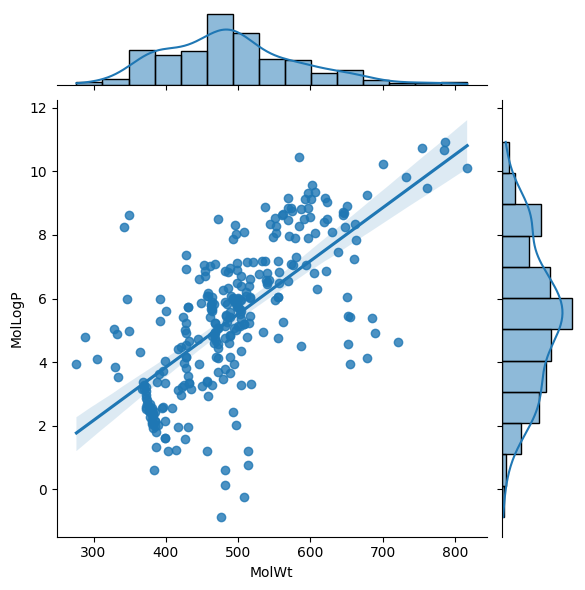

In [39]:
joint_plt = sns.jointplot(x='MolWt', y='MolLogP', data=df_selected, kind='reg')

In the scatter plot, an upward trend in the distribution of points can be observed. This suggests that, on average, molecules with higher molecular weight also have higher MolLogP values.
The regression line, which has a positive slope, confirms this trend. The line shows the average relationship between MolWt and MolLogP, and the shaded band indicates confidence in this relationship.

Larger molecules (with higher MolWt) often have more carbon and hydrogen atoms, which increases their lipophilicity (and hence their MolLogP).
Molecules with long side chains or many aromatic rings tend to be more lipophilic due to the greater number of hydrophobic interactions.

The positive correlation observed suggests that in the dataset analyzed, as molecules increase in size (and weight), they also become more lipophilic.
However, the scatter around the regression line indicates that this is not an absolute rule and that there are exceptions. Other structural and functional factors also influence MolLogP.

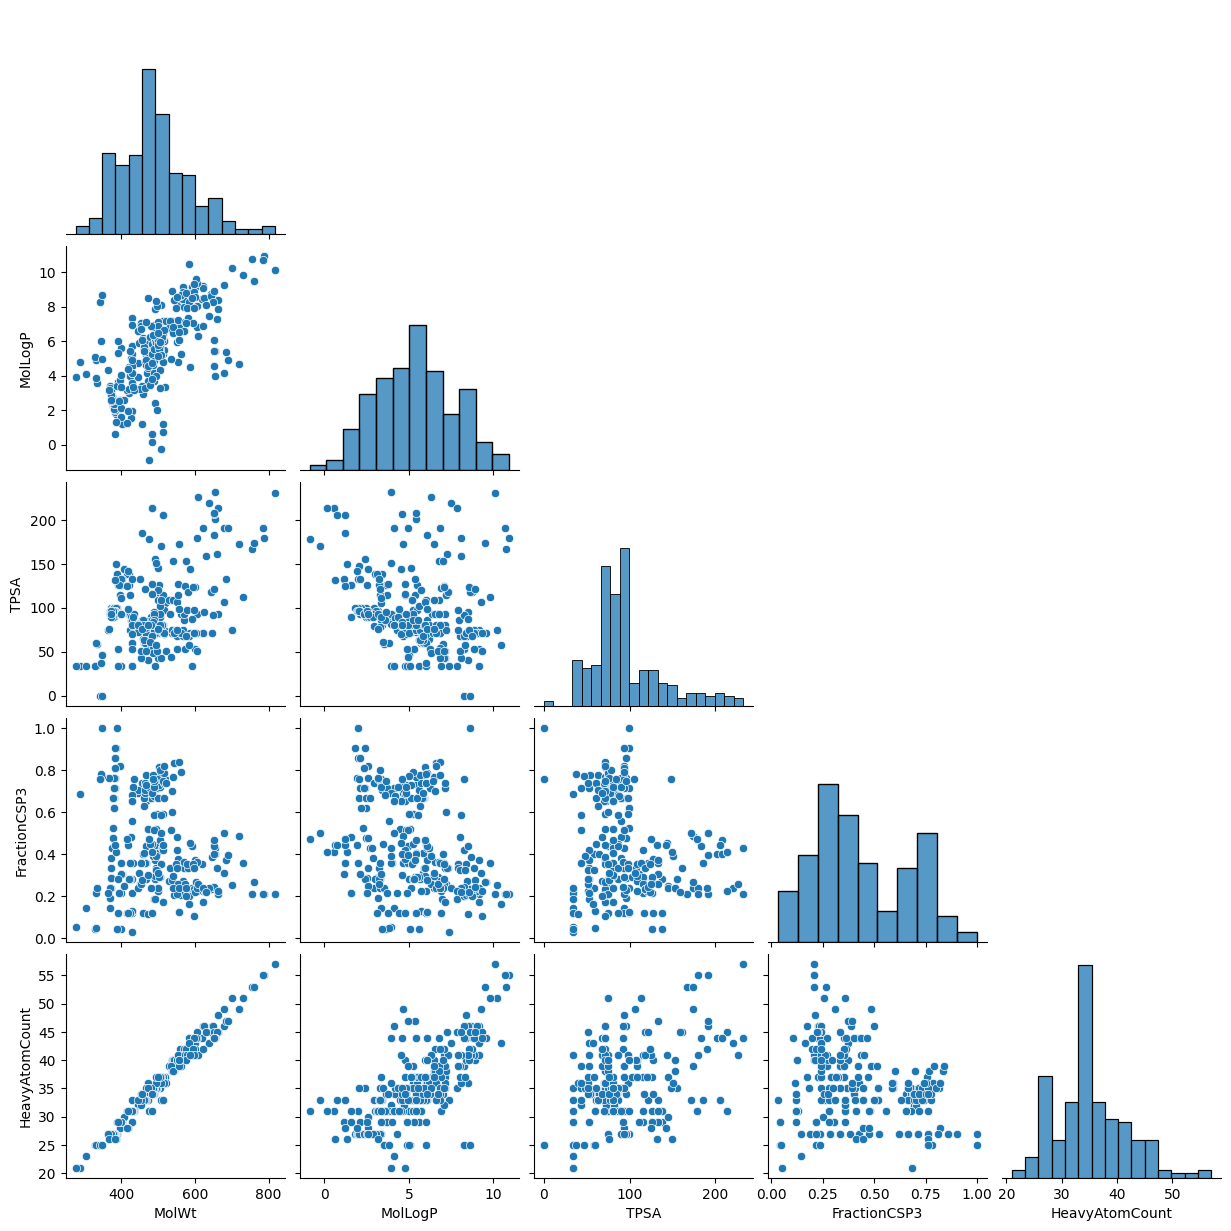

In [40]:
sns.pairplot(df_selected[["MolWt", "MolLogP", "TPSA", "FractionCSP3", "HeavyAtomCount"]], corner="true")

# TO DO: describe the graphs

### TPSA "Topological Polar Surface Area"

## Heat Map

Text(0.5, 1.0, 'Molecular Descriptors Correlation Heat Map')

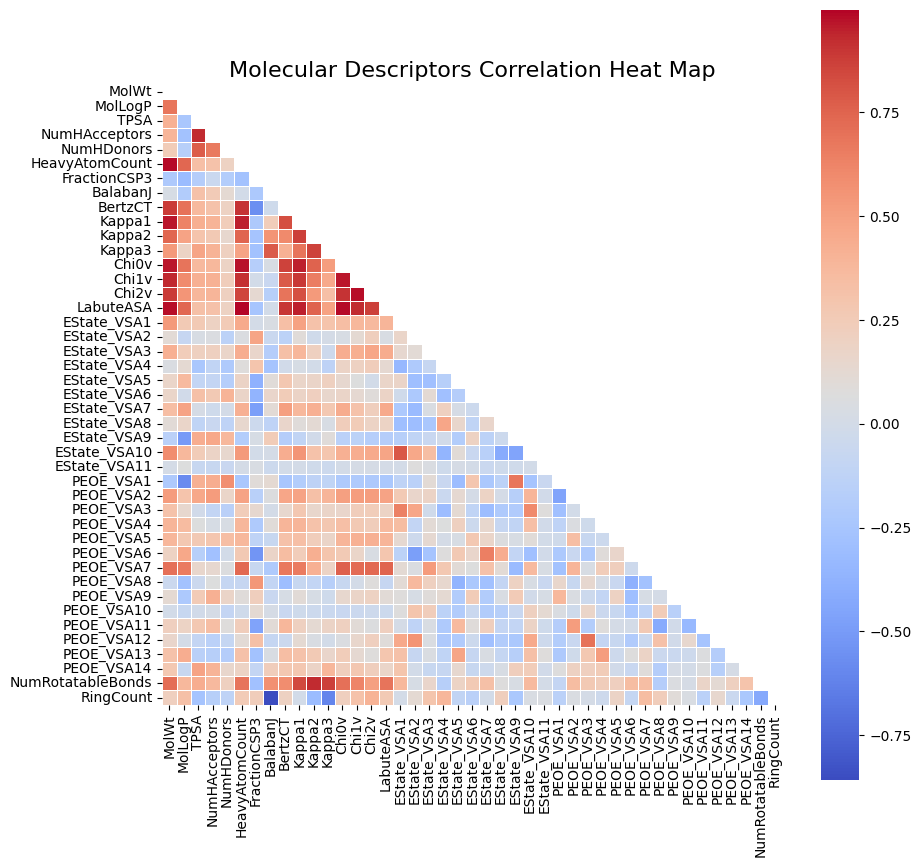

In [41]:
# A data frame with the selected_descriptors
df_selected_descriptors = df[selected_descriptors] #se crea un data frame con solo los nombres de las columnas de molecular descriptors elegidas

# Calculate the correlation matrix with the Pearson coefficient
correlation = df_selected_descriptors.corr(method='pearson')

# plot just the half of the triangle, using a mask
upper_triangle = np.triu(np.ones_like(correlation)) #np.triu makes the half of the matrix (a triangle)

# Size ajusting
fig = plt.gcf()
fig.set_size_inches(10, 10)

# Create the heatmap
sns.heatmap(correlation, annot=False, mask=upper_triangle, square=True, cmap='coolwarm', linewidths=0.5)

plt.title('Molecular Descriptors Correlation Heat Map', size=16)


# 4. Data Processing <a name="procesamiento-de-datos"></a>

## 4.1 Generate the PCA

In [42]:
df_selected

SMILES  delta_G  MolWt  \
0        COc1cc(C=CC(=O)CC(=O)C=Cc2ccc(O)c(OC)c2)ccc1O    -8.92 368.39   
1          COc1cc(C=CC(O)CC(O)C=Cc2ccc(O)c(OC)c2)ccc1O    -8.52 372.42   
2         COc1cc(C=CC(=O)CC(O)C=Cc2ccc(O)c(OC)c2)ccc1O    -8.48 370.40   
3          COc1cc(CCC(=O)CC(=O)CCc2ccc(O)c(OC)c2)ccc1O    -8.93 372.42   
4         COc1cc(C=CC(=O)CC(=O)CCc2ccc(O)c(OC)c2)ccc1O    -8.94 370.40   
..                                                 ...      ...    ...   
290  COCOC(=CC=CCC(=O)CC(=O)C=CC=CC(CN)CO[PH](=O)(=...   -10.69 513.37   
291  COCOC(=CC=CCC(=O)CC(=O)C=CC=CC(C)CN)CO[PH](=O)...    -9.61 417.40   
292  COCOC(=CC=CCC(=O)CC(=O)C=CC=CC(CN)CNS(C)(=O)=O...    -9.39 507.63   
293   COCOC(=CC=CCC(=O)CC(=O)C=CC=CC(C)CN)CNS(C)(=O)=O    -9.70 414.52   
294  COCOC(=CC=CCC(=O)CC(=O)C=CC=CC(CN)CO[PH](=O)(=...   -10.59 513.46   

     MolLogP   TPSA  NumHAcceptors  NumHDonors  HeavyAtomCount  FractionCSP3  \
0       3.37  93.06              6           2              27          0.14   
1       2.95  99.38              6           4              27          0.24   
2       3.16  96.22              6           3              27          0.19   
3       3.21  93.06              6           2              27          0.33   
4       3.29  93.06              6           2              27          0.24   
..       ...    ...            ...         ...             ...           ...   
290     1.21 205.82             11           3              33          0.44   
291     1.95 142.22              8           2              28          0.44   
292    -0.25 170.96              9           3              33          0.50   
293     1.22 124.79              7           2              28          0.47   
294     0.75 205.82             11           3              33          0.44   

     BalabanJ  ...  PEOE_VSA7  PEOE_VSA8  PEOE_VSA9  PEOE_VSA10  PEOE_VSA11  \
0        1.96  ...      47.54       0.00      20.64        0.00       34.56   
1        1.94  ...      35.39       6.42      26.43        0.00       23.00   
2        1.95  ...      41.47       6.42      20.32        0.00       28.78   
3        1.79  ...      48.23      12.84      20.64       11.57       23.00   
4        1.87  ...      47.89       6.42      20.64        5.78       28.78   
..        ...  ...        ...        ...        ...         ...         ...   
290      4.58  ...      12.15      25.99      13.03       18.15       12.58   
291      4.49  ...      24.61      13.53       6.42       18.15       12.58   
292      4.58  ...      18.70      25.99      25.48       11.54       12.58   
293      4.49  ...      24.61      13.53      19.22       11.54       12.58   
294      4.58  ...      12.15      25.99      13.03       18.15       12.58   

     PEOE_VSA12  PEOE_VSA13  PEOE_VSA14  NumRotatableBonds  RingCount  
0          0.00        0.00        0.00                  8          2  
1          0.00        0.00        0.00                  8          2  
2          0.00        0.00        0.00                  8          2  
3          0.00        0.00        0.00                 10          2  
4          0.00        0.00        0.00                  9          2  
..          ...         ...         ...                ...        ...  
290        0.00        0.00       14.95                 18          0  
291        0.00        0.00        7.48                 15          0  
292       20.05        0.00        0.00                 18          0  
293       10.02        0.00        0.00                 15          0  
294        0.00        0.00       17.87                 18          0  

[295 rows x 45 columns]

### Split the data

In [43]:
#Split Matrix betwenn X and y
X = df_selected.iloc[:,2:] #All the columns except SMILES and delta_G
y = df_selected.iloc[:,1] #delta_G

### Train, Test division

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape},  y_test: {y_test.shape}")

X_train: (206, 43), y_train: (206,)
X_test: (89, 43),  y_test: (89,)


### Normalise the data

In [45]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Use the PCA

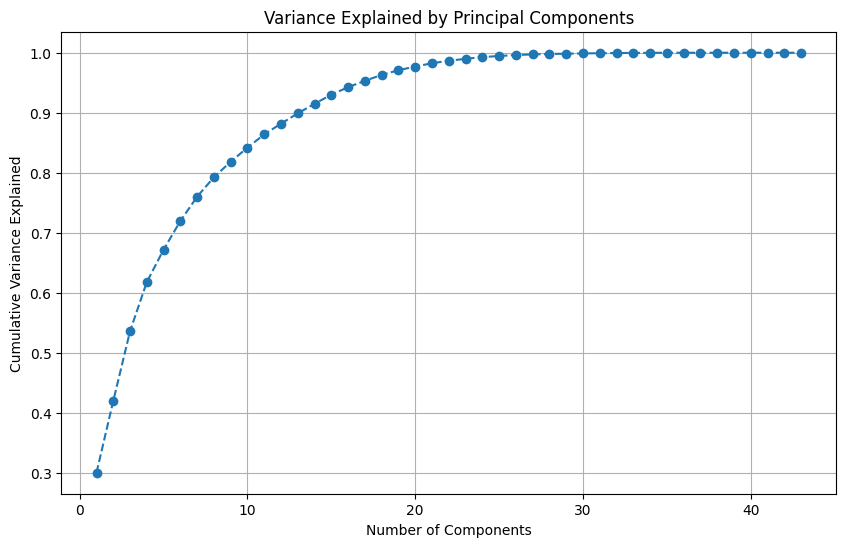

In [46]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot Cumulative Explained Variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Variance Explained by Principal Components')
plt.grid()
plt.show()

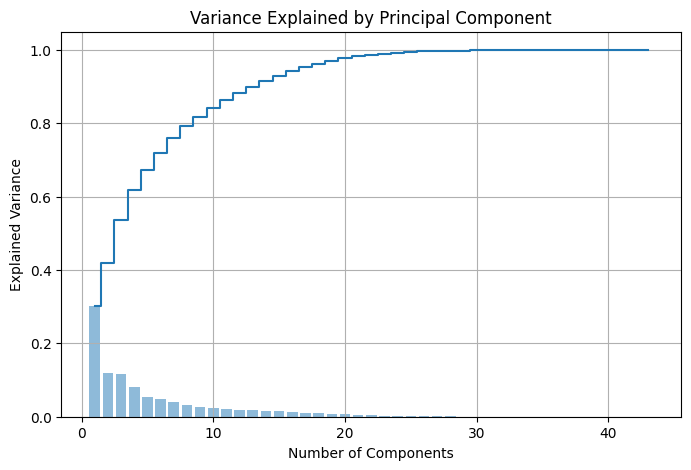

In [47]:
# Graph the variance explained by each component
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Variance Explained by Principal Component')
plt.grid()
plt.show()

In [48]:
# Determine the number of components that explain at least 95% of the variance
variance_threshold = 0.95
num_components_95 = np.argmax(cumulative_variance >= variance_threshold) + 1
print(f'Number of components that explain at least 95% of the variance: {num_components_95}')

Number of components that explain at least 95% of the variance: 17


In [49]:
# PCA application
pca = PCA(n_components=num_components_95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

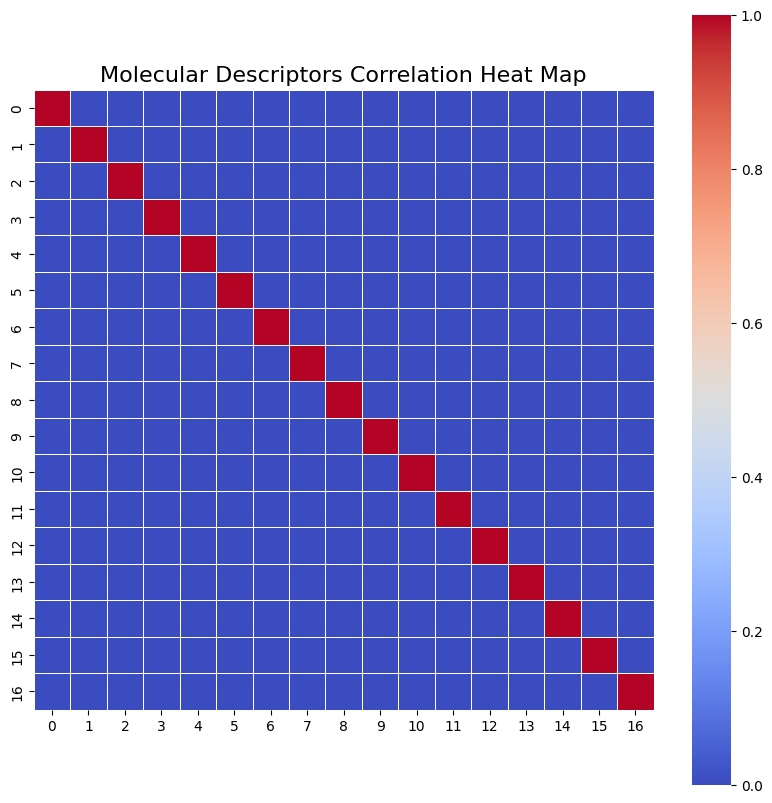

In [50]:
# Calculate the correlation matrix of the original molecular descriptors
correlation_original = pd.DataFrame(X_train_pca).corr(method='pearson')

fig = plt.gcf()
fig.set_size_inches(10, 10)

sns.heatmap(correlation_original, annot=False, square=True, cmap='coolwarm', linewidths=0.5)

plt.title('Molecular Descriptors Correlation Heat Map', size=16)

plt.show()

Se trata de una matriz diagonal, lo cual es correcto. Las componentes principales son ortogonales entre sí, haciendo que la correlación entre ellas sea cero.

## 4.2 Feature Importance

In [51]:
#Split Matrix betwenn X and y
X = df.iloc[:,2:] #All the columns except SMILES and delta_G
y = df.iloc[:,1] #delta_G
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
"""

'\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\nscaler = StandardScaler()\nX_train = scaler.fit_transform(X_train)\nX_test = scaler.transform(X_test)\n'

In [52]:
# RandomForest Model to get Feature Importance
model = RandomForestRegressor(n_estimators = 250,
                               random_state = 0)
# Model train
model.fit(X, y)

#  Feature Importance Calculation
importances = model.feature_importances_

df_importances = pd.DataFrame(data = zip(X.columns, importances),
                              columns = ["Columns", "Importance"])

df_importances = df_importances.sort_values("Importance", ascending = False)

#print("Feature Importance:")

for index, (feature, importance) in enumerate(df_importances.values):

    print(f"{index + 1:2}. feature {index:2} ({importance:20}): {feature}")

 1. feature  0 (  0.3028746076531795): qed
 2. feature  1 (  0.1601173191190415): Chi0
 3. feature  2 (  0.0683532829990307): BCUT2D_MRHI
 4. feature  3 ( 0.06323914286318878): PEOE_VSA2
 5. feature  4 ( 0.03121191486342726): Kappa3
 6. feature  5 (0.018993133271889288): MinEStateIndex
 7. feature  6 (0.017148115010947967): VSA_EState2
 8. feature  7 ( 0.01669347444107622): Kappa1
 9. feature  8 ( 0.01667883481238358): NumHDonors
10. feature  9 ( 0.01621704798088736): VSA_EState5
11. feature 10 (0.011551962487959361): EState_VSA2
12. feature 11 (0.010104435588973008): MolMR
13. feature 12 (0.008541024069818812): MinAbsEStateIndex
14. feature 13 (0.007356706401562512): VSA_EState8
15. feature 14 (0.006853863260607979): EState_VSA8
16. feature 15 (  0.0061123948184639): PEOE_VSA9
17. feature 16 (0.006056283879428821): EState_VSA3
18. feature 17 (0.0060372368903799075): SlogP_VSA3
19. feature 18 (0.005856251642580137): MolLogP
20. feature 19 (0.0055999572532888404): TPSA
21. feature 20 (0

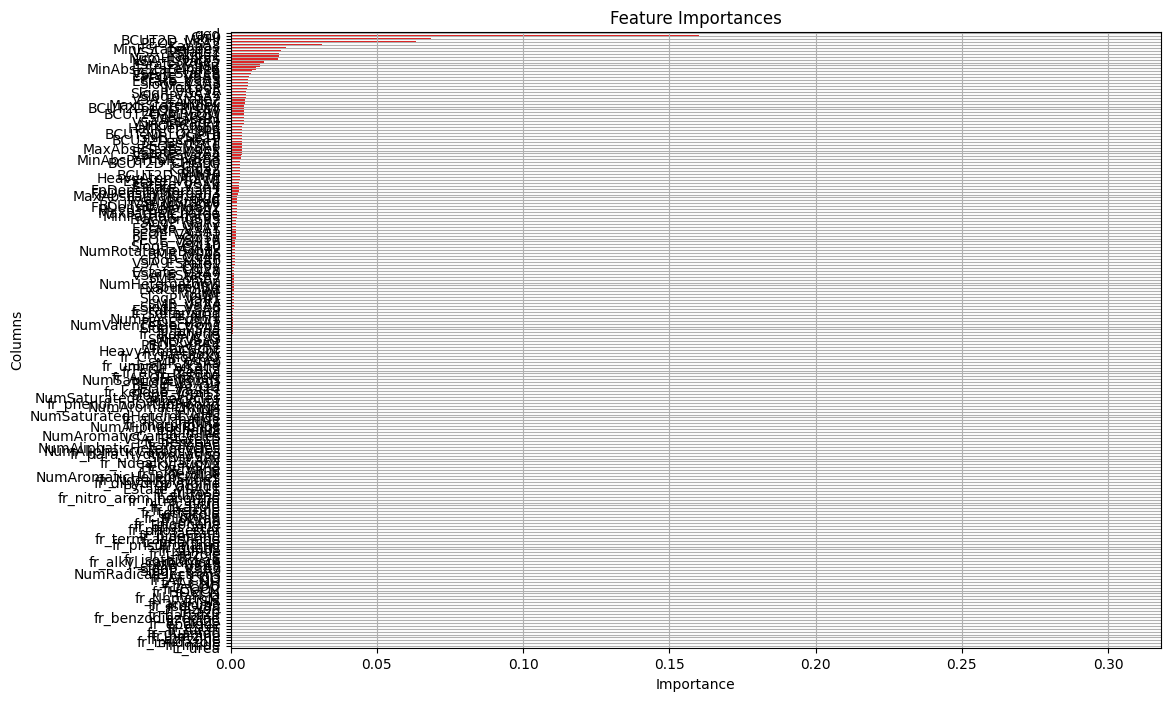

In [53]:
plt.figure(figsize = (12, 8))

plt.title("Feature Importances")
sns.barplot(x = df_importances["Importance"], y = df_importances["Columns"], color = "red")

plt.grid()
plt.show()

In [54]:
# Select the characteristics that explain 95% of the accumulated importance
total_importance = df_importances["Importance"].sum()
cumulative_importance = 0.0
num_features = 0

for importance in df_importances["Importance"]:
    cumulative_importance += importance
    num_features += 1
    if cumulative_importance / total_importance >= 0.95:
        break #cuando la suma sobrepase el 95% para

top_features_95 = df_importances.head(num_features)["Columns"].tolist()

print(f"\nNumber of features that explain 95% of the total importance: {num_features}")

print(f"\nTop {num_features} features explaining 95% of total importance:")

print(top_features_95)

# New data frame with the 95% of the total importance
df_fi = X[top_features_95]
df_fi['scoring'] = y


Number of features that explain 95% of the total importance: 69

Top 69 features explaining 95% of total importance:
['qed', 'Chi0', 'BCUT2D_MRHI', 'PEOE_VSA2', 'Kappa3', 'MinEStateIndex', 'VSA_EState2', 'Kappa1', 'NumHDonors', 'VSA_EState5', 'EState_VSA2', 'MolMR', 'MinAbsEStateIndex', 'VSA_EState8', 'EState_VSA8', 'PEOE_VSA9', 'EState_VSA3', 'SlogP_VSA3', 'MolLogP', 'TPSA', 'SlogP_VSA12', 'SlogP_VSA5', 'VSA_EState7', 'AvgIpc', 'MaxEStateIndex', 'BCUT2D_LOGPLOW', 'PEOE_VSA7', 'BCUT2D_MRLOW', 'SMR_VSA1', 'BalabanJ', 'VSA_EState3', 'NHOHCount', 'HallKierAlpha', 'SPS', 'BCUT2D_LOGPHI', 'SMR_VSA10', 'BCUT2D_CHGHI', 'BertzCT', 'PEOE_VSA6', 'MaxAbsEStateIndex', 'EState_VSA5', 'VSA_EState4', 'PEOE_VSA8', 'MinAbsPartialCharge', 'BCUT2D_CHGLO', 'Chi2v', 'Kappa2', 'Chi3n', 'BCUT2D_MWHI', 'HeavyAtomMolWt', 'EState_VSA10', 'EState_VSA6', 'EState_VSA4', 'FpDensityMorgan1', 'FpDensityMorgan3', 'MaxAbsPartialCharge', 'fr_allylic_oxid', 'VSA_EState6', 'BCUT2D_MWLOW', 'FpDensityMorgan2', 'PEOE_VSA1',

In [55]:
df_fi.shape

(295, 70)

In [56]:
df_fi.head()

qed  Chi0  BCUT2D_MRHI  PEOE_VSA2  Kappa3  MinEStateIndex  VSA_EState2  \
0 0.55 19.81         6.10       9.59    5.74           -0.35        23.86   
1 0.57 19.81         5.57       0.00    6.06           -0.85         0.00   
2 0.62 19.81         5.94       4.79    5.90           -0.95        11.99   
3 0.62 19.81         5.99       9.59    6.02           -0.12        24.10   
4 0.52 19.81         6.06       9.59    5.88           -0.30        23.98   

   Kappa1  NumHDonors  VSA_EState5  ...  PEOE_VSA1  MaxPartialCharge  \
0   19.78           2        -0.08  ...      19.69              0.16   
1   20.35           4         0.78  ...      29.90              0.16   
2   20.07           3         0.45  ...      24.79              0.16   
3   20.29           2         0.59  ...      19.69              0.16   
4   20.04           2         0.25  ...      19.69              0.16   

   MinPartialCharge  FractionCSP3  SlogP_VSA2  Chi1v  EState_VSA1  SMR_VSA5  \
0             -0.50          0.14       36.00   8.08         0.00      6.42   
1             -0.50          0.24       46.85   8.39        12.21     18.63   
2             -0.50          0.19       41.43   8.24         6.10     12.52   
3             -0.50          0.33       36.00   8.68         0.00     32.10   
4             -0.50          0.24       36.00   8.38         0.00     19.26   

   PEOE_VSA11  scoring  
0       34.56    -8.92  
1       23.00    -8.52  
2       28.78    -8.48  
3       23.00    -8.93  
4       28.78    -8.94  

[5 rows x 70 columns]

In [57]:

X = df_fi.iloc[:, :-1]
y = df_fi.iloc[:, -1]

X_fi_train, X_fi_test, y_fi_train, y_fi_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_fi_train: {X_fi_train.shape}, y_fi_train: {y_train.shape}")
print(f"X_fi_test: {X_fi_test.shape},  y_fi_test: {y_test.shape}")

X_fi_train: (206, 69), y_fi_train: (206,)
X_fi_test: (89, 69),  y_fi_test: (89,)


Now there is 2 sets of data.

One with **PCA**
X_train_pca
X_test_pca

and one with **Feature Importance**
df_fi

# 5. Machine Learning Models <a name="modelo-de-machine-learning"></a>

## 5.A Supervised Machine Learning Models (1/3)

*   Lineal Regresion 04 y 05
*   Decision Tree 12
*   kNN 06

In [58]:
X_train_pca.shape


(206, 17)

In [59]:
y_train.shape

(206,)

Regresión Lineal Múltiple

Linear Regression with Original Data - Mean Squared Error: 0.1997258677698625
Linear Regression with Original Data - R^2 Score: 0.6942186208887529


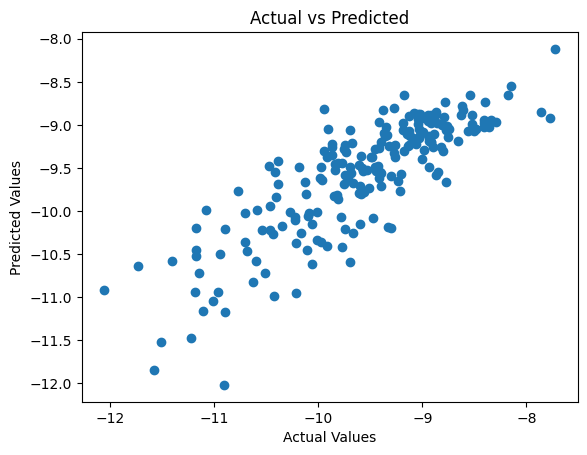

Coefficients: [-0.16670084  0.01940477 -0.06233386 -0.00082217 -0.12025365 -0.1249159
 -0.01336458 -0.08621576 -0.03325084  0.01001778 -0.00728429 -0.02902995
 -0.05536403 -0.00619428  0.05225804  0.01122299 -0.04515654]
Intercept: -9.576469980582525


In [60]:
"""
# Cargar los datos iniciales
df = database #usar los datos de: X_train_pca, X_test_pca, y_train, y_test

# Seleccionar características y objetivo
X = df[['Derivative']]  # Utilizando 'Derivative' como característica
y = df['min deltaG ']  # 'min deltaG' como objetivo

# Realizar PCA
n_components = 1  # Solo hay una característica en este caso, PCA no es necesario  ##hay más características.
# pca = PCA(n_components=n_components)
# X_pca = pca.fit_transform(X)  # Esto no tiene sentido con una sola característica, así que usaremos X directamente

"""
# Regresión Múltiple utilizando las variables de PCA (ver 4.1)
model = LinearRegression()
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_train_pca)

# Evaluación del modelo
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"Linear Regression with Original Data - Mean Squared Error: {mse}")
print(f"Linear Regression with Original Data - R^2 Score: {r2}")

# Graficar resultados
plt.scatter(y_train, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.show()

# Coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

## Falta dibujar una línea de tendencia de los puntos

### Decision Tree

In [61]:
"""
# Decision Tree 12
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt  # Asegúrate de importar matplotlib si aún no lo has hecho

# Create the model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)  # Asume que X_train y y_train ya contienen el 100% de los datos

# Plotting the tree
plt.figure(figsize=(20,10))
plot_tree(tree_model, filled=True, feature_names=['Derivative'], rounded=True)
plt.show()

print(f"Decision Tree Mean Squared Error: {mse_tree}")
print(f"Decision Tree R^2 Score: {r2_tree}")
"""

'\n# Decision Tree 12\nfrom sklearn.tree import DecisionTreeRegressor, plot_tree\nimport matplotlib.pyplot as plt  # Asegúrate de importar matplotlib si aún no lo has hecho\n\n# Create the model\ntree_model = DecisionTreeRegressor(random_state=42)\ntree_model.fit(X_train, y_train)  # Asume que X_train y y_train ya contienen el 100% de los datos\n\n# Plotting the tree\nplt.figure(figsize=(20,10))\nplot_tree(tree_model, filled=True, feature_names=[\'Derivative\'], rounded=True)\nplt.show()\n\nprint(f"Decision Tree Mean Squared Error: {mse_tree}")\nprint(f"Decision Tree R^2 Score: {r2_tree}")\n'

El error viene de usar otras X y otras y. Recuerda usar | X_train_pca | X_test_pca | y_train | y_test |

### KNN

In [62]:
from sklearn.neighbors import KNeighborsRegressor

# Create the model
knn_model = KNeighborsRegressor(n_neighbors=6) #es 6 el mejor valor aquí?
knn_model.fit(X_train_pca, y_train)

# Predictions
y_pred_knn = knn_model.predict(X_test_pca)

# Evaluation
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"kNN Mean Squared Error: {mse_knn}")
print(f"kNN R^2 Score: {r2_knn}")

kNN Mean Squared Error: 0.25114070739900546
kNN R^2 Score: 0.6093978479478965


¿Está hecho aquí el tuning? ¿Has jugado con los valores de *k*? Es directamente 6 el mejor valor¿?

Falta usar modelos de validación. Leave One Out o utilizar GridSearchCV para los 3 modelos

## 5.B Supervised Machine Learning Models (2/3)

*   Random Forest 13
*   SVM 15
*   GBM 17

In [63]:
#RANDOM FOREST

random_forest = RandomForestRegressor(n_estimators=200, random_state=42)
random_forest.fit(X_train_pca, y_train)
y_pred_rf = random_forest.predict(X_test_pca)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf  =mean_squared_error(y_test,y_pred_rf)**0.5
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest MAE: {mae_rf}")
print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest RMSE: {rmse_rf}")
print(f"Random Forest R2: {r2_rf}")

Random Forest MAE: 0.39970537353932706
Random Forest MSE: 0.2512031448687722
Random Forest RMSE: 0.501201700783998
Random Forest R2: 0.6093007382028768


In [64]:
metrics_df_rf = pd.DataFrame({
    "Model" : ["Random Forest Regressor"],
    "MAE" :[mae_rf],
    "MSE": [mse_rf],
    "RMSE": [rmse_rf],
    "R-squared": [r2_rf]
})

print (metrics_df_rf)

                     Model  MAE  MSE  RMSE  R-squared
0  Random Forest Regressor 0.40 0.25  0.50       0.61


In [65]:
#Mejores parámetros ---> takes +2min

# Búsqueda de hiperparámetros (Grid Search)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=3)
grid_search.fit(X_train_pca, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.249 total time=   0.4s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.217 total time=   0.5s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.319 total time=   0.4s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.299 total time=   0.5s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.153 total time=   0.4s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.252 total time=   0.5s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.217 total time=   0.5s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, s

In [66]:
#mismo con los mejores parámetros

y_pred_rf = grid_search.best_estimator_.predict(X_test_pca)
mae_rf = mean_absolute_error (y_test,y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test,y_pred_rf)**0.5
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest MAE: {mae_rf}")
print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest RMSE: {rmse_rf}")
print(f"Random Forest R2: {r2_rf}")

Random Forest MAE: 0.4016289947021538
Random Forest MSE: 0.25492378792709436
Random Forest RMSE: 0.50489978008224
Random Forest R2: 0.6035139774636493


In [67]:
y_pred_rf_train = grid_search.best_estimator_.predict(X_train_pca)
print(r2_score(y_train, y_pred_rf_train))

0.9368103233689714


In [68]:
# SVM

svm = SVR(kernel='rbf', C=1.0, epsilon=0.2)
svm.fit(X_train_pca, y_train)
y_pred_svm = svm.predict(X_test_pca)
mae_svm = mean_absolute_error(y_test,y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)
rmse_svm = mean_squared_error(y_test,y_pred_svm)**0.5
r2_svm = r2_score(y_test, y_pred_svm)
print(f"SVM MAE: {mae_svm}")
print(f"SVM MSE: {mse_svm}")
print(f"SVM RMSE: {rmse_svm}")
print(f"SVM R2: {r2_svm}")


SVM MAE: 0.41400693048522025
SVM MSE: 0.2703598184289148
SVM RMSE: 0.5199613624385131
SVM R2: 0.5795061342286866


In [69]:
metrics_df_svm = pd.DataFrame({
    "Model" : ["Support Vector Machine"],
    "MAE" :[mae_svm],
    "MSE": [mse_svm],
    "RMSE": [rmse_svm],
    "R-squared": [r2_svm]
})

print (metrics_df_svm)

                    Model  MAE  MSE  RMSE  R-squared
0  Support Vector Machine 0.41 0.27  0.52       0.58


In [70]:
X_train_pca.shape,y_train.shape

((206, 17), (206,))

In [71]:
#Búsqueda de hiperparámetros (GridSearch)


param_grid_svm = {
    "C":[0.1,1,10],
    "kernel" : ["linear","poly","rbf","sigmoid"],
    "gamma": ["scale","auto"]}
grid_search_svm = GridSearchCV(estimator=SVR(), param_grid=param_grid_svm, cv=5, scoring='neg_mean_squared_error', verbose=3)
grid_search_svm.fit(X_train_pca, y_train)


best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

y_pred_svm = grid_search_svm.best_estimator_.predict(X_test_pca)
mae_svm =mean_absolute_error (y_test,y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)
rmse_svm = mean_squared_error(y_test,y_pred_svm)**0.5
r2_svm = r2_score(y_test, y_pred_svm)
print(f"SVM MAE: {mae_svm}")
print(f"SVM MSE: {mse_svm}")
print(f"SVM RMSE: {rmse_svm}")
print(f"SVM R2: {r2_svm}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=0.1, gamma=scale, kernel=linear;, score=-0.263 total time=   0.0s
[CV 2/5] END C=0.1, gamma=scale, kernel=linear;, score=-0.322 total time=   0.0s
[CV 3/5] END C=0.1, gamma=scale, kernel=linear;, score=-0.246 total time=   0.0s
[CV 4/5] END C=0.1, gamma=scale, kernel=linear;, score=-0.218 total time=   0.0s
[CV 5/5] END C=0.1, gamma=scale, kernel=linear;, score=-0.225 total time=   0.0s
[CV 1/5] END ..C=0.1, gamma=scale, kernel=poly;, score=-0.421 total time=   0.0s
[CV 2/5] END ..C=0.1, gamma=scale, kernel=poly;, score=-0.379 total time=   0.0s
[CV 3/5] END ..C=0.1, gamma=scale, kernel=poly;, score=-0.825 total time=   0.0s
[CV 4/5] END ..C=0.1, gamma=scale, kernel=poly;, score=-0.443 total time=   0.0s
[CV 5/5] END ..C=0.1, gamma=scale, kernel=poly;, score=-0.275 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=rbf;, score=-0.296 total time=   0.0s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=rbf;

In [72]:
y_pred_svm_train = grid_search_svm.best_estimator_.predict(X_train_pca)
print(r2_score(y_train, y_pred_svm_train))

0.6377530307729005


In [73]:
# GBM

gbm = GradientBoostingRegressor(random_state=20)
gbm.fit(X_train_pca, y_train)
y_pred_gbm = gbm.predict(X_test_pca)
mae_gbm = mean_absolute_error(y_test, y_pred_gbm)
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
rmse_gbm = mean_squared_error(y_test,y_pred_gbm)**0.5
r2_gbm = r2_score(y_test, y_pred_gbm)
print(f"GBM MAE: {mae_gbm}")
print(f"GBM MSE: {mse_gbm}")
print(f"GBM RMSE: {rmse_gbm}")
print(f"GBM R2: {r2_gbm}")

GBM MAE: 0.40290836412429193
GBM MSE: 0.2526499893116227
GBM RMSE: 0.5026430038423122
GBM R2: 0.6070504437009816


In [74]:
metrics_df_gmb = pd.DataFrame({
    "Model" : ["Gradient Boosting"],
    "MAE" :[mae_gbm],
    "MSE": [mse_gbm],
    "RMSE": [rmse_gbm],
    "R-squared": [r2_gbm]
})

print (metrics_df_gmb)

               Model  MAE  MSE  RMSE  R-squared
0  Gradient Boosting 0.40 0.25  0.50       0.61


In [75]:
# Búsqueda de hiperparámetros (Grid Search)


param_grid_boost = {"learning_rate":[0.1,0.001,0.01],
    "n_estimators":[100,200,300]}

grid_search_boost = GridSearchCV(estimator=GradientBoostingRegressor(random_state=20), param_grid=param_grid_boost, cv=5, scoring='neg_mean_squared_error', verbose=3)
grid_search_boost.fit(X_train_pca, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.1, n_estimators=100;, score=-0.247 total time=   0.1s
[CV 2/5] END learning_rate=0.1, n_estimators=100;, score=-0.245 total time=   0.1s
[CV 3/5] END learning_rate=0.1, n_estimators=100;, score=-0.324 total time=   0.1s
[CV 4/5] END learning_rate=0.1, n_estimators=100;, score=-0.348 total time=   0.1s
[CV 5/5] END learning_rate=0.1, n_estimators=100;, score=-0.185 total time=   0.2s
[CV 1/5] END learning_rate=0.1, n_estimators=200;, score=-0.255 total time=   0.3s
[CV 2/5] END learning_rate=0.1, n_estimators=200;, score=-0.265 total time=   0.3s
[CV 3/5] END learning_rate=0.1, n_estimators=200;, score=-0.337 total time=   0.3s
[CV 4/5] END learning_rate=0.1, n_estimators=200;, score=-0.359 total time=   0.3s
[CV 5/5] END learning_rate=0.1, n_estimators=200;, score=-0.198 total time=   0.3s
[CV 1/5] END learning_rate=0.1, n_estimators=300;, score=-0.255 total time=   0.4s
[CV 2/5] END learning_rate=

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=20),
             param_grid={'learning_rate': [0.1, 0.001, 0.01],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=3)

In [76]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


In [77]:
y_pred_gmb = grid_search_boost.best_estimator_.predict(X_test_pca)
mae_gmb =mean_absolute_error(y_test,y_pred_gmb)
mse_gmb = mean_squared_error(y_test, y_pred_gmb)
rmse_gmb = mean_squared_error(y_test,y_pred_gmb)**0.5
r2_gmb = r2_score(y_test, y_pred_gmb)
print(f"GMB MAE: {mae_gmb}")
print(f"GMB MSE: {mse_gmb}")
print(f"GMB RMSE: {rmse_gmb}")
print(f"GMB R2: {r2_gmb}")

GMB MAE: 0.40013014129582325
GMB MSE: 0.26256389194742946
GMB RMSE: 0.5124098866605029
GMB R2: 0.5916312321168207


In [78]:
y_pred_boost_train_pca = grid_search_boost.best_estimator_.predict(X_train_pca)
print("R2 best estimator: ", r2_score(y_train, y_pred_boost_train_pca))

R2 best estimator:  0.8778174419520207


In [84]:
#KERNEL RIDGE -- peor

param_grid_kr = {
    "alpha":[0.1,1,10],
    "kernel" : ["additive_chi2", "chi2", "linear", "poly", "polynomial", "rbf", "laplacian", "sigmoid", "cosine"]}
#poner algun parámetro más
grid_search_kr = GridSearchCV(estimator=KernelRidge(), param_grid=param_grid_kr, cv=5, scoring='neg_mean_squared_error', verbose=3)
grid_search_kr.fit(X_train_pca, y_train)


best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


y_pred_kr = grid_search_kr.best_estimator_.predict(X_test_pca)
mae_kr =mean_absolute_error (y_test,y_pred_kr)
mse_kr = mean_squared_error(y_test, y_pred_kr)
rmse_kr = mean_squared_error(y_test,y_pred_kr)**0.5
r2_kr = r2_score(y_test, y_pred_kr)
print(f"KR MAE: {mae_kr}")
print(f"KR MSE: {mse_kr}")
print(f"KR RMSE: {rmse_kr}")
print(f"KR R2: {r2_kr}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END .....alpha=0.1, kernel=additive_chi2;, score=nan total time=   0.0s
[CV 2/5] END .....alpha=0.1, kernel=additive_chi2;, score=nan total time=   0.0s
[CV 3/5] END .....alpha=0.1, kernel=additive_chi2;, score=nan total time=   0.0s
[CV 4/5] END .....alpha=0.1, kernel=additive_chi2;, score=nan total time=   0.0s
[CV 5/5] END .....alpha=0.1, kernel=additive_chi2;, score=nan total time=   0.0s
[CV 1/5] END ..............alpha=0.1, kernel=chi2;, score=nan total time=   0.0s
[CV 2/5] END ..............alpha=0.1, kernel=chi2;, score=nan total time=   0.0s
[CV 3/5] END ..............alpha=0.1, kernel=chi2;, score=nan total time=   0.0s
[CV 4/5] END ..............alpha=0.1, kernel=chi2;, score=nan total time=   0.0s
[CV 5/5] END ..............alpha=0.1, kernel=chi2;, score=nan total time=   0.0s
[CV 1/5] END .......alpha=0.1, kernel=linear;, score=-104.764 total time=   0.0s
[CV 2/5] END .......alpha=0.1, kernel=linear;, 

In [85]:
#BAYESIAN RIDGE -- de los que mejor funciona

param_grid_br = {
    "alpha_1":[10e-4,10e-5,10e-6,10e-7],
    "lambda_1":[10e-4,10e-5,10e-6,10e-7],
    }
#poner algun parámetro más
grid_search_br = GridSearchCV(estimator=BayesianRidge(), param_grid=param_grid_br, cv=5, scoring='neg_mean_squared_error', verbose=3)
grid_search_br.fit(X_train_pca, y_train)


best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


y_pred_br = grid_search_br.best_estimator_.predict(X_test_pca)
mae_br =mean_absolute_error (y_test,y_pred_br)
mse_br = mean_squared_error(y_test, y_pred_br)
rmse_br = mean_squared_error(y_test,y_pred_br)**0.5
r2_br = r2_score(y_test, y_pred_br)
print(f"BR MAE: {mae_br}")
print(f"BR MSE: {mse_br}")
print(f"BR RMSE: {rmse_br}")
print(f"BR R2: {r2_br}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ....alpha_1=0.001, lambda_1=0.001;, score=-0.247 total time=   0.0s
[CV 2/5] END ....alpha_1=0.001, lambda_1=0.001;, score=-0.275 total time=   0.0s
[CV 3/5] END ....alpha_1=0.001, lambda_1=0.001;, score=-0.230 total time=   0.0s
[CV 4/5] END ....alpha_1=0.001, lambda_1=0.001;, score=-0.243 total time=   0.0s
[CV 5/5] END ....alpha_1=0.001, lambda_1=0.001;, score=-0.205 total time=   0.0s
[CV 1/5] END ...alpha_1=0.001, lambda_1=0.0001;, score=-0.247 total time=   0.0s
[CV 2/5] END ...alpha_1=0.001, lambda_1=0.0001;, score=-0.275 total time=   0.0s
[CV 3/5] END ...alpha_1=0.001, lambda_1=0.0001;, score=-0.230 total time=   0.0s
[CV 4/5] END ...alpha_1=0.001, lambda_1=0.0001;, score=-0.243 total time=   0.0s
[CV 5/5] END ...alpha_1=0.001, lambda_1=0.0001;, score=-0.205 total time=   0.0s
[CV 1/5] END ....alpha_1=0.001, lambda_1=1e-05;, score=-0.247 total time=   0.0s
[CV 2/5] END ....alpha_1=0.001, lambda_1=1e-05;,

In [86]:
#Tabla comparacion

results={
    "Model": ["Random Forest","Support Vector Machine","Gradient Boosting Machine","Kernel Ridge","Bayesian Ridge"],
    "MAE": [mae_rf,mae_svm,mae_gmb,mae_kr,mae_br],
    "MSE":[mse_rf,mse_svm,mse_gmb,mse_kr,mse_br],
    "RMSE":[rmse_svm,rmse_rf,rmse_gmb,rmse_kr,rmse_br],
    "R2":[r2_rf,r2_svm,r2_gmb,r2_kr,r2_br],

}

df_results=pd.DataFrame(results)
df_results

Model  MAE  MSE  RMSE    R2
0              Random Forest 0.40 0.25  0.51  0.60
1     Support Vector Machine 0.38 0.26  0.50  0.60
2  Gradient Boosting Machine 0.40 0.26  0.51  0.59
3               Kernel Ridge 0.64 1.15  1.07 -0.79
4             Bayesian Ridge 0.35 0.21  0.46  0.67

In [87]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train_pca, X_test_pca, y_train, y_test)

 26%|██▌       | 11/42 [00:00<00:01, 17.90it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 76%|███████▌  | 32/42 [00:02<00:00, 11.55it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.
QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


100%|██████████| 42/42 [00:05<00:00,  7.49it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1195
[LightGBM] [Info] Number of data points in the train set: 206, number of used features: 17
[LightGBM] [Info] Start training from score -9.576470
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [88]:
results = {
    'models': models,
    'predictions': predictions
}




El modelo SVM es mejor que los modelos GBM y RF, ya que su valor de R² es mayor (un valor más cercano a 1 es mejor) y sus errores son más bajos.

Existen modelos mejores, como por ejemplo Bayesian Ridge, que nos da un R² de 0,67, cercano a 0,70. Podemos considerar este modelo como bueno.

Dado que existen modelos mucho peores, como KR, que incluso nos da un R² negativo, podemos considerar que los tres modelos (SVM, GBM y RF) son buenos.


## 5.C Supervised Machine Learning Models (3/3) Artificial Neural Network

*   Perceptron Neural Networks 42
*   Convolutional Neural Networks (CNN) 44
*   Recurrent Neural Networks (RNN) 48

Modelos Neuronales

Perceptron


In [89]:
"""
# Variables
X = df_selected.iloc[:,2:] #All the columns except SMILES and delta_G
y = df_selected.iloc[:,1]

# Train, Test division

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Normalise the data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# PCA application
pca = PCA(n_components=num_components_95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


#Entreno el modelo
model = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
model.fit(X_train_pca, y_train)
print (model)

#Predicciones
y_pred = model.predict(X_test_pca)

#Resultado prediccion


y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Exactitud del modelo: {accuracy}')
"""


'\n# Variables\nX = df_selected.iloc[:,2:] #All the columns except SMILES and delta_G\ny = df_selected.iloc[:,1]\n\n# Train, Test division\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\nprint(f"X_train: {X_train.shape}, y_train: {y_train.shape}")\nprint(f"X_test: {X_test.shape}, y_test: {y_test.shape}")\n\n# Normalise the data\n\nscaler = StandardScaler()\nX_train = scaler.fit_transform(X_train)\nX_test = scaler.transform(X_test)\n\n\n# PCA application\npca = PCA(n_components=num_components_95)\nX_train_pca = pca.fit_transform(X_train)\nX_test_pca = pca.transform(X_test)\n\n\n#Entreno el modelo\nmodel = Perceptron(max_iter=1000, tol=1e-3, random_state=42)\nmodel.fit(X_train_pca, y_train)\nprint (model)\n\n#Predicciones\ny_pred = model.predict(X_test_pca)\n\n#Resultado prediccion\n\n\ny_pred = model.predict(X_test)\naccuracy = accuracy_score(y_test, y_pred)\nprint(f\'Exactitud del modelo: {accuracy}\')\n'

*Convulacion*

In [90]:
X = df_selected.iloc[:,2:] #All the columns except SMILES and delta_G
y = df_selected.iloc[:,1]



# Train, Test division

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Asegurarse de que y_train y y_test sean matrices 2D
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# Normalise the data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



# PCA application
num_components_95 = 17
pca = PCA(n_components=num_components_95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


X_train: (236, 43), y_train: (236,)
X_test: (59, 43), y_test: (59,)


In [95]:
model = Sequential()

# Capa de Entrada
model.add(Input(shape = (X_train_pca.shape[1],1)))


# Convolucionales + Pooling (1D)
model.add(Conv1D(filters = 32, kernel_size = 1, activation = "relu"))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters = 64, kernel_size = 1, activation = "relu"))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters = 128, kernel_size = 1, activation = "relu"))
model.add(GlobalMaxPool1D())

# Capa de Salida
model.add(Dense(units = 1))

model.compile(optimizer = "adam",
              loss      = "mse",
              metrics   = ["mae"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 17, 32)            64        
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 5, 32)             0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 5, 64)             2112      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 128)            8320      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)              

In [96]:
history = model.fit(x=X_train_pca,
                    y=y_train,
                    validation_data=(X_test_pca, y_test),
                    epochs=10)


Epoch 1/10
8/8 [==============================] - 2s 47ms/step - loss: 94.4488 - mae: 9.6753 - val_loss: 78.7899 - val_mae: 8.8418
Epoch 2/10
8/8 [==============================] - 0s 10ms/step - loss: 69.6937 - mae: 8.2969 - val_loss: 53.0473 - val_mae: 7.2248
Epoch 3/10
8/8 [==============================] - 0s 8ms/step - loss: 44.4280 - mae: 6.5656 - val_loss: 26.6781 - val_mae: 4.9916
Epoch 4/10
8/8 [==============================] - 0s 8ms/step - loss: 20.2160 - mae: 4.1843 - val_loss: 7.6649 - val_mae: 2.3818
Epoch 5/10
8/8 [==============================] - 0s 11ms/step - loss: 6.6580 - mae: 2.1172 - val_loss: 8.9109 - val_mae: 2.2584
Epoch 6/10
8/8 [==============================] - 0s 9ms/step - loss: 7.7168 - mae: 2.2133 - val_loss: 9.8448 - val_mae: 2.3556
Epoch 7/10
8/8 [==============================] - 0s 10ms/step - loss: 6.5541 - mae: 2.0646 - val_loss: 6.2576 - val_mae: 2.0006
Epoch 8/10
8/8 [==============================] - 0s 11ms/step - loss: 5.7629 - mae: 1.9876 -

In [97]:
y_hat = model.predict(X_test_pca)
y_hat = [0 if x < 0.5 else 1 for x in y_hat.flatten()]


2/2 [==============================] - 0s 6ms/step


In [98]:
r2_svm = r2_score(y_test, y_hat)
r2_svm


-134.9544040319246

In [99]:

# Dividir los datos en conjuntos de entrenamiento y prueba
X = df_selected.iloc[:, 2:]  # Todas las columnas excepto SMILES y delta_G
y = df_selected.iloc[:, 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Normalizar los datos
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Asegurarse de que y_train y y_test sean matrices 2D
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# Normalizar y_train y y_test
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Aplicar PCA
num_components_95 = 17  # Definir el número de componentes como en el código anterior
pca = PCA(n_components=num_components_95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Reshape para Conv1D (necesita 3 dimensiones: samples, timesteps, features)
X_train_pca = X_train_pca.reshape((X_train_pca.shape[0], X_train_pca.shape[1], 1))
X_test_pca = X_test_pca.reshape((X_test_pca.shape[0], X_test_pca.shape[1], 1))

# Crear el modelo CNN
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(num_components_95, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train_pca, y_train, epochs=50, verbose=1, validation_data=(X_test_pca, y_test))

# Predecir
y_hat = model.predict(X_test_pca)

# Invertir la normalización para obtener las predicciones en la escala original
y_hat_inverse = scaler_y.inverse_transform(y_hat)
y_test_inverse = scaler_y.inverse_transform(y_test)

# Métricas
# Mean Squared Error
mse = mean_squared_error(y_test_inverse, y_hat_inverse)

# Root Mean Squared Error
rmse = np.sqrt(mse)

# R2 Score
r2 = r2_score(y_test_inverse, y_hat_inverse)

# Mean Absolute Error
mae = mean_absolute_error(y_test_inverse, y_hat_inverse)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R2 Score: {r2}")
print(f"Mean Absolute Error: {mae}")


X_train: (236, 43), y_train: (236,)
X_test: (59, 43), y_test: (59,)
Epoch 1/50
8/8 [==============================] - 1s 31ms/step - loss: 0.9041 - val_loss: 0.6729
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.6065 - val_loss: 0.4970
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.4816 - val_loss: 0.4463
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.4276 - val_loss: 0.4506
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.3713 - val_loss: 0.4263
Epoch 6/50
8/8 [==============================] - 0s 9ms/step - loss: 0.3396 - val_loss: 0.4297
Epoch 7/50
8/8 [==============================] - 0s 8ms/step - loss: 0.3093 - val_loss: 0.4158
Epoch 8/50
8/8 [==============================] - 0s 9ms/step - loss: 0.2838 - val_loss: 0.4312
Epoch 9/50
8/8 [==============================] - 0s 7ms/step - loss: 0.2724 - val_loss: 0.4148
Epoch 10/50
8/8 [==============================] - 0s 10ms/step -

RNN

In [100]:


X = df_selected.iloc[:, 2:].values  # Todas las columnas excepto SMILES y delta_G
y = df_selected.iloc[:, 1].values

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Normalizar los datos
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Evaluar que los datos esten redimensionados
X_train_rnn = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_rnn = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Construcción del modelo
rnn_modelo = Sequential()
rnn_modelo.add(SimpleRNN(50, activation='relu', input_shape=(1, X_train_rnn.shape[2])))
rnn_modelo.add(Dense(1))  # Salida para regresión

rnn_modelo.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
rnn_modelo.summary()

# Entrenamiento
rnn_modelo.fit(X_train_rnn, y_train, epochs=50, batch_size=32, validation_split=0.2)


X_train: (236, 43), y_train: (236,)
X_test: (59, 43), y_test: (59,)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                4700      
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 4751 (18.56 KB)
Trainable params: 4751 (18.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
6/6 [==============================] - 2s 108ms/step - loss: 104.3656 - mae: 10.1815 - val_loss: 100.0464 - val_mae: 9.9846
Epoch 2/50
6/6 [==============================] - 0s 18ms/step - loss: 97.6311 - mae: 9.8514 - val_loss: 94.7847 - val_mae: 9.7170
Epoch 3/50
6/6 [==============================] - 0s 19ms/step - loss: 91.2322 - m

In [102]:
# Evaluación del modelo RNN
rnn_loss, rnn_mae = rnn_modelo.evaluate(X_test_rnn, y_test)
print(f"RNN - Loss: {rnn_loss}, MAE: {rnn_mae}")

2/2 [==============================] - 0s 8ms/step - loss: 3.1421 - mae: 1.3916
RNN - Loss: 3.1420938968658447, MAE: 1.3915684223175049


In [103]:
rnn_predicciones = rnn_modelo.predict(X_test_rnn)

print("Predicciones:", rnn_predicciones[:5])
print("Valores reales:", y_test[:5])


2/2 [==============================] - 0s 7ms/step
Predicciones: [[ -8.464938 ]
 [ -9.869014 ]
 [ -8.624845 ]
 [ -7.0489607]
 [-12.483051 ]]
Valores reales: [ -9.390746  -9.636948  -9.716915  -8.598392 -11.92192 ]


## 5.D Unsupervised Machine Learning Models

*   K-Means Clustering 20
*   DBscan 21
*   Clustering Hierarchical 22

Para este modelo, se harán diferentes agrupaciones de descriptores moleculares.

### Crear una función para realizar los 3 modelos de clustering

In [104]:
def clustering_pipeline(df):

  # Split the data
  X = df.iloc[:, 2:]  # all but SMILES and delta_G
  y = df.iloc[:, 1]  # delta_G

  # Train, Test division
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  # Normalize the data  #minmax para escalado.
  #scaler = StandardScaler()
  scaler = MinMaxScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  # A new dictionary to save the results

  # K-Means Clustering
  clustering_results = {}

  # Reduce dimensionality to X main components for visualization
  pca = PCA(n_components=2)
  X_train_pca = pca.fit_transform(X_train)

  # clusters = 3
  kmeans = KMeans(n_clusters=3)
  kmeans_labels = kmeans.fit_predict(X_train)

  # Transform cluster centers to PCA space
  kmeans_centers_pca = pca.transform(kmeans.cluster_centers_)

  clustering_results['Kmeans'] = {
      'labels': kmeans_labels,
      'silhouette': silhouette_score(X_train, kmeans_labels),
      'davies_bouldin': davies_bouldin_score(X_train, kmeans_labels),
      'calinski_harabasz': calinski_harabasz_score(X_train, kmeans_labels)
      }

  # DBSCAN Clustering
  dbscan = DBSCAN(eps=0.3, min_samples=5)
  dbscan_labels = dbscan.fit_predict(X_train)

  # Filter noise points to calculate metrics
  mask = dbscan_labels != -1
  valid_dbscan_labels = dbscan_labels[mask]
  valid_X_train = X_train[mask]
  clustering_results['DBSCAN'] = {
      'labels': dbscan_labels,
      'silhouette': silhouette_score(valid_X_train, valid_dbscan_labels) if len(set(valid_dbscan_labels)) > 1 else -1,
      'davies_bouldin': davies_bouldin_score(valid_X_train, valid_dbscan_labels) if len(set(valid_dbscan_labels)) > 1 else -1,
      'calinski_harabasz': calinski_harabasz_score(valid_X_train, valid_dbscan_labels) if len(set(valid_dbscan_labels)) > 1 else -1
      }

  # Hierarchical Clustering
  Z  = linkage(X_train, method='ward')
  hierarchical_labels = fcluster(Z, t=3, criterion='maxclust')
  clustering_results['Hierarchical'] = {
      'labels': hierarchical_labels,
      'silhouette': silhouette_score(X_train, hierarchical_labels),
      'davies_bouldin': davies_bouldin_score(X_train, hierarchical_labels),
      'calinski_harabasz': calinski_harabasz_score(X_train, hierarchical_labels)
      }

  # Plot the results
  fig, axes = plt.subplots(1, 3, figsize=(18, 6))

  # Plot K-Means
  sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=kmeans_labels, palette='Accent', ax=axes[0])
  axes[0].scatter(kmeans_centers_pca[:, 0], kmeans_centers_pca[:, 1], color='red', marker='*', s=200)
  axes[0].set_title('K-Means Clustering')

  # Plot DBSCAN
  sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=dbscan_labels, palette='Accent', ax=axes[1])
  axes[1].set_title('DBSCAN Clustering')

  # Plot Hierarchical
  sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=hierarchical_labels, palette='Accent', ax=axes[2])
  axes[2].set_title('Hierarchical Clustering')

  plt.show()

  return clustering_results
  # end of the function code

1. Usar la función con todos los datos

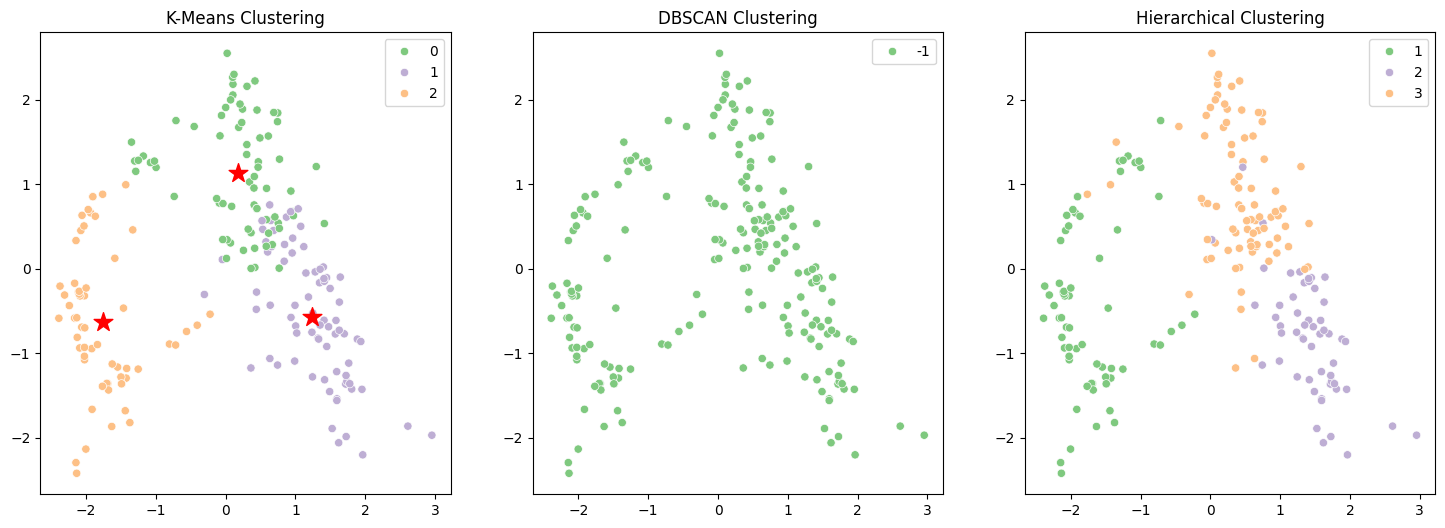

Kmeans:
  Silhouette Score: 0.21130433953330313
  Davies-Bouldin Index: 1.8687503483071144
  Calinski-Harabasz Index: 49.68146488074456
DBSCAN:
  Silhouette Score: -1
  Davies-Bouldin Index: -1
  Calinski-Harabasz Index: -1
Hierarchical:
  Silhouette Score: 0.18712798374905862
  Davies-Bouldin Index: 2.058864923512667
  Calinski-Harabasz Index: 44.082857771004946


In [105]:
# Select the group descriptors

selected_descriptors = [
    "MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt",
    "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge",
    "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI",
    "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc",
    "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n",
    "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2", "Kappa3", "LabuteASA", "PEOE_VSA1", "PEOE_VSA10", "PEOE_VSA11",
    "PEOE_VSA12", "PEOE_VSA13", "PEOE_VSA14", "PEOE_VSA2", "PEOE_VSA3", "PEOE_VSA4", "PEOE_VSA5", "PEOE_VSA6", "PEOE_VSA7",
    "PEOE_VSA8", "PEOE_VSA9", "SMR_VSA1", "SMR_VSA10", "SMR_VSA2", "SMR_VSA3", "SMR_VSA4", "SMR_VSA5", "SMR_VSA6", "SMR_VSA7",
    "SMR_VSA8", "SMR_VSA9", "SlogP_VSA1", "SlogP_VSA10", "SlogP_VSA11", "SlogP_VSA12", "SlogP_VSA2", "SlogP_VSA3", "SlogP_VSA4",
    "SlogP_VSA5", "SlogP_VSA6", "SlogP_VSA7", "SlogP_VSA8", "SlogP_VSA9", "TPSA", "EState_VSA1", "EState_VSA10", "EState_VSA11",
    "EState_VSA2", "EState_VSA3", "EState_VSA4", "EState_VSA5", "EState_VSA6", "EState_VSA7", "EState_VSA8", "EState_VSA9",
    "VSA_EState1", "VSA_EState10", "VSA_EState2", "VSA_EState3", "VSA_EState4", "VSA_EState5", "VSA_EState6", "VSA_EState7",
    "VSA_EState8", "VSA_EState9", "FractionCSP3", "HeavyAtomCount", "NHOHCount", "NOCount", "NumAliphaticCarbocycles",
    "NumAliphaticHeterocycles", "NumAliphaticRings", "NumAromaticCarbocycles", "NumAromaticHeterocycles", "NumAromaticRings",
    "NumHAcceptors", "NumHDonors", "NumHeteroatoms", "NumRotatableBonds", "NumSaturatedCarbocycles", "NumSaturatedHeterocycles",
    "NumSaturatedRings", "RingCount", "MolLogP", "MolMR", "fr_Al_COO", "fr_Al_OH", "fr_Al_OH_noTert", "fr_ArN", "fr_Ar_COO",
    "fr_Ar_N", "fr_Ar_NH", "fr_Ar_OH", "fr_COO", "fr_COO2", "fr_C_O", "fr_C_O_noCOO", "fr_C_S", "fr_HOCCN", "fr_Imine", "fr_NH0",
    "fr_NH1", "fr_NH2", "fr_N_O", "fr_Ndealkylation1", "fr_Ndealkylation2", "fr_Nhpyrrole", "fr_SH", "fr_aldehyde",
    "fr_alkyl_carbamate", "fr_alkyl_halide", "fr_allylic_oxid", "fr_amide", "fr_amidine", "fr_aniline", "fr_aryl_methyl",
    "fr_azide", "fr_azo", "fr_barbitur", "fr_benzene", "fr_benzodiazepine", "fr_bicyclic", "fr_diazo", "fr_dihydropyridine",
    "fr_epoxide", "fr_ester", "fr_ether", "fr_furan", "fr_guanido", "fr_halogen", "fr_hdrzine", "fr_hdrzone", "fr_imidazole",
    "fr_imide", "fr_isocyan", "fr_isothiocyan", "fr_ketone", "fr_ketone_Topliss", "fr_lactam", "fr_lactone", "fr_methoxy",
    "fr_morpholine", "fr_nitrile", "fr_nitro", "fr_nitro_arom", "fr_nitro_arom_nonortho", "fr_nitroso", "fr_oxazole", "fr_oxime",
    "fr_para_hydroxylation", "fr_phenol", "fr_phenol_noOrthoHbond", "fr_phos_acid", "fr_phos_ester", "fr_piperdine",
    "fr_piperzine", "fr_priamide", "fr_prisulfonamd", "fr_pyridine", "fr_quatN", "fr_sulfide", "fr_sulfonamd", "fr_sulfone",
    "fr_term_acetylene", "fr_tetrazole", "fr_thiazole", "fr_thiocyan", "fr_thiophene", "fr_unbrch_alkane", "fr_urea"
]


""" New DataFrame with the new data

smiles_list = database['curated_SMILES'].tolist()
delta_G = database['min deltaG '].tolist()

df_D = pd.DataFrame(columns=['SMILES', 'delta_G'] + selected_descriptors)

for i, smiles in enumerate(smiles_list):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        descriptor_values = [Descriptors.__dict__[desc](mol) for desc in selected_descriptors]
        df_D.loc[len(df_D)] = [smiles, delta_G[i]] + descriptor_values
"""

df_D = df[selected_descriptors]

# Call the function
results = clustering_pipeline(df_D)

# Print the results
for method, metrics in results.items():
    print(f"{method}:")
    print(f"  Silhouette Score: {metrics['silhouette']}")
    print(f"  Davies-Bouldin Index: {metrics['davies_bouldin']}")
    print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz']}")

In [106]:
df_D.shape

(295, 210)

2. Usar la función con los datos de feature importance

In [107]:
print(top_features_95)

['qed', 'Chi0', 'BCUT2D_MRHI', 'PEOE_VSA2', 'Kappa3', 'MinEStateIndex', 'VSA_EState2', 'Kappa1', 'NumHDonors', 'VSA_EState5', 'EState_VSA2', 'MolMR', 'MinAbsEStateIndex', 'VSA_EState8', 'EState_VSA8', 'PEOE_VSA9', 'EState_VSA3', 'SlogP_VSA3', 'MolLogP', 'TPSA', 'SlogP_VSA12', 'SlogP_VSA5', 'VSA_EState7', 'AvgIpc', 'MaxEStateIndex', 'BCUT2D_LOGPLOW', 'PEOE_VSA7', 'BCUT2D_MRLOW', 'SMR_VSA1', 'BalabanJ', 'VSA_EState3', 'NHOHCount', 'HallKierAlpha', 'SPS', 'BCUT2D_LOGPHI', 'SMR_VSA10', 'BCUT2D_CHGHI', 'BertzCT', 'PEOE_VSA6', 'MaxAbsEStateIndex', 'EState_VSA5', 'VSA_EState4', 'PEOE_VSA8', 'MinAbsPartialCharge', 'BCUT2D_CHGLO', 'Chi2v', 'Kappa2', 'Chi3n', 'BCUT2D_MWHI', 'HeavyAtomMolWt', 'EState_VSA10', 'EState_VSA6', 'EState_VSA4', 'FpDensityMorgan1', 'FpDensityMorgan3', 'MaxAbsPartialCharge', 'fr_allylic_oxid', 'VSA_EState6', 'BCUT2D_MWLOW', 'FpDensityMorgan2', 'PEOE_VSA1', 'MaxPartialCharge', 'MinPartialCharge', 'FractionCSP3', 'SlogP_VSA2', 'Chi1v', 'EState_VSA1', 'SMR_VSA5', 'PEOE_VSA11

[21:22:50] DEPRECATION WARNING: please use MorganGenerator
[21:22:50] DEPRECATION WARNING: please use MorganGenerator
[21:22:50] DEPRECATION WARNING: please use MorganGenerator
[21:22:50] DEPRECATION WARNING: please use MorganGenerator
[21:22:50] DEPRECATION WARNING: please use MorganGenerator
[21:22:50] DEPRECATION WARNING: please use MorganGenerator
[21:22:50] DEPRECATION WARNING: please use MorganGenerator
[21:22:50] DEPRECATION WARNING: please use MorganGenerator
[21:22:50] DEPRECATION WARNING: please use MorganGenerator
[21:22:50] DEPRECATION WARNING: please use MorganGenerator
[21:22:50] DEPRECATION WARNING: please use MorganGenerator
[21:22:50] DEPRECATION WARNING: please use MorganGenerator
[21:22:50] DEPRECATION WARNING: please use MorganGenerator
[21:22:50] DEPRECATION WARNING: please use MorganGenerator
[21:22:50] DEPRECATION WARNING: please use MorganGenerator
[21:22:50] DEPRECATION WARNING: please use MorganGenerator
[21:22:50] DEPRECATION WARNING: please use MorganGenerat

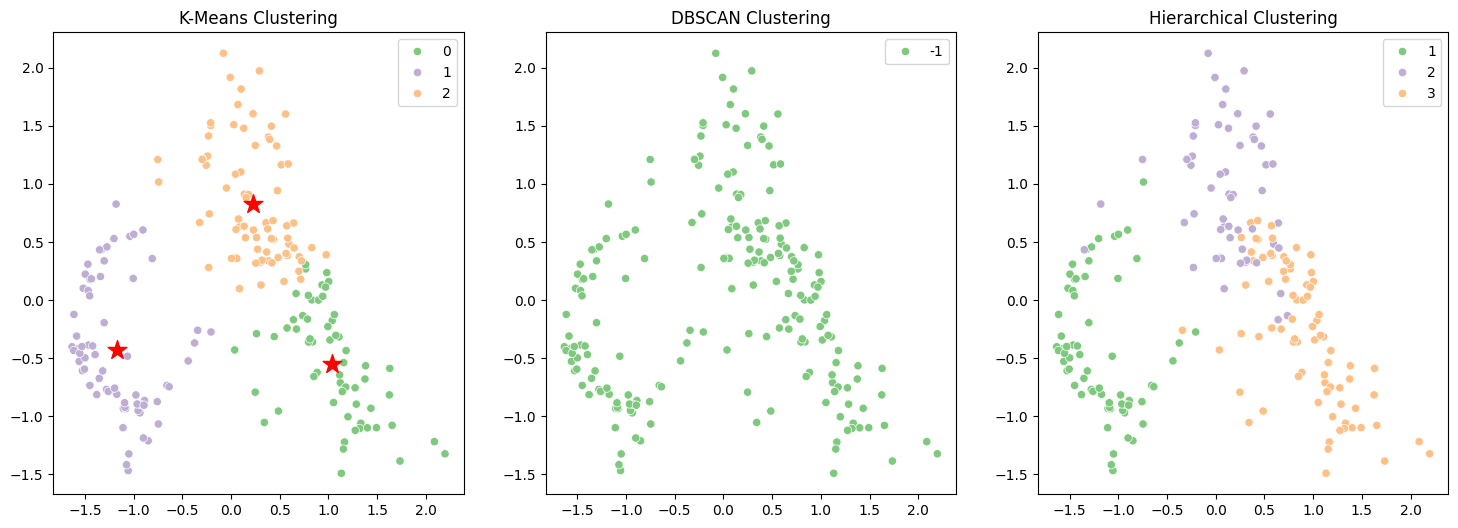

Kmeans:
  Silhouette Score: 0.24405310199815605
  Davies-Bouldin Index: 1.6785274360268418
  Calinski-Harabasz Index: 61.781696153218164
DBSCAN:
  Silhouette Score: -1
  Davies-Bouldin Index: -1
  Calinski-Harabasz Index: -1
Hierarchical:
  Silhouette Score: 0.24278914687183575
  Davies-Bouldin Index: 1.750508534292868
  Calinski-Harabasz Index: 57.8578668892061


In [108]:
# Select the group descriptors

selected_descriptors = top_features_95

# New DataFrame with the new data

smiles_list = database['curated_SMILES'].tolist()
delta_G = database['min deltaG '].tolist()

df_D = pd.DataFrame(columns=['SMILES', 'delta_G'] + selected_descriptors)

for i, smiles in enumerate(smiles_list):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        descriptor_values = [Descriptors.__dict__[desc](mol) for desc in selected_descriptors]
        df_D.loc[len(df_D)] = [smiles, delta_G[i]] + descriptor_values

# Call the function
results = clustering_pipeline(df_D)

# Print the results
for method, metrics in results.items():
    print(f"{method}:")
    print(f"  Silhouette Score: {metrics['silhouette']}")
    print(f"  Davies-Bouldin Index: {metrics['davies_bouldin']}")
    print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz']}")

In [109]:
df_D.shape

(295, 71)

### Group 1 EState Descriptors

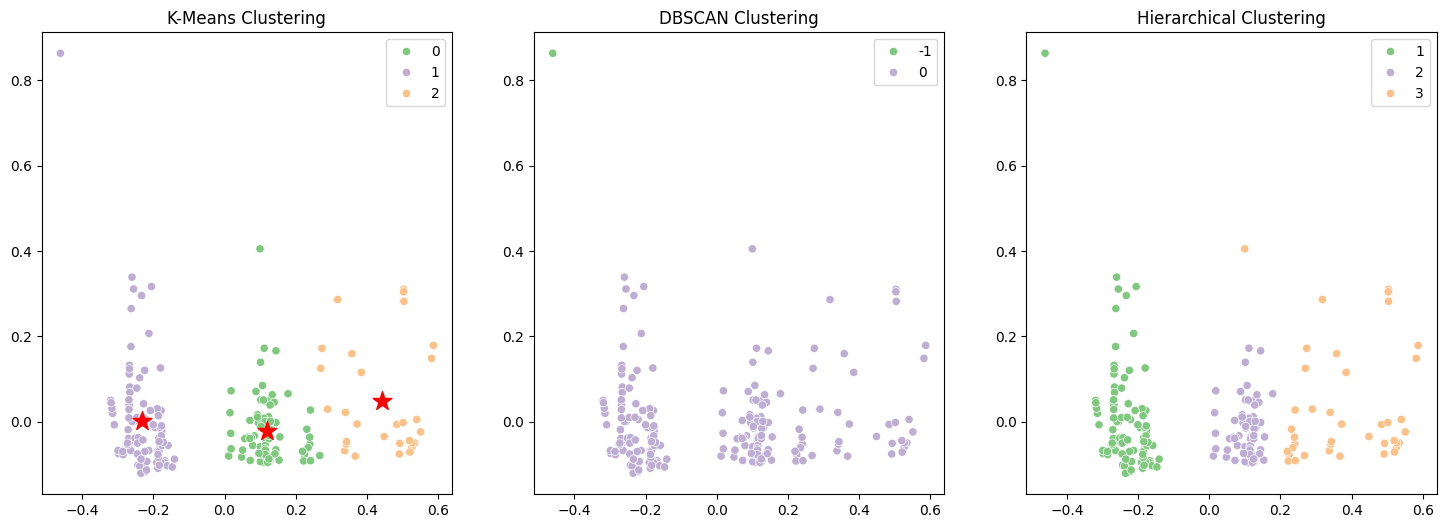

Kmeans:
  Silhouette Score: 0.6141479110081594
  Davies-Bouldin Index: 0.6248042610864619
  Calinski-Harabasz Index: 359.79438016394556
DBSCAN:
  Silhouette Score: -1
  Davies-Bouldin Index: -1
  Calinski-Harabasz Index: -1
Hierarchical:
  Silhouette Score: 0.5671523218229119
  Davies-Bouldin Index: 0.7040136880412043
  Calinski-Harabasz Index: 325.75632929863383


In [110]:
# Select the group descriptors

selected_descriptors = [
    'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex'
]

# New DataFrame with the new data

df_D = df[selected_descriptors]

# Call the function
results = clustering_pipeline(df_D)

# Print the results
for method, metrics in results.items():
    print(f"{method}:")
    print(f"  Silhouette Score: {metrics['silhouette']}")
    print(f"  Davies-Bouldin Index: {metrics['davies_bouldin']}")
    print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz']}")

In [111]:
df_D.shape

(295, 4)

### Group 2 Molecular Properties

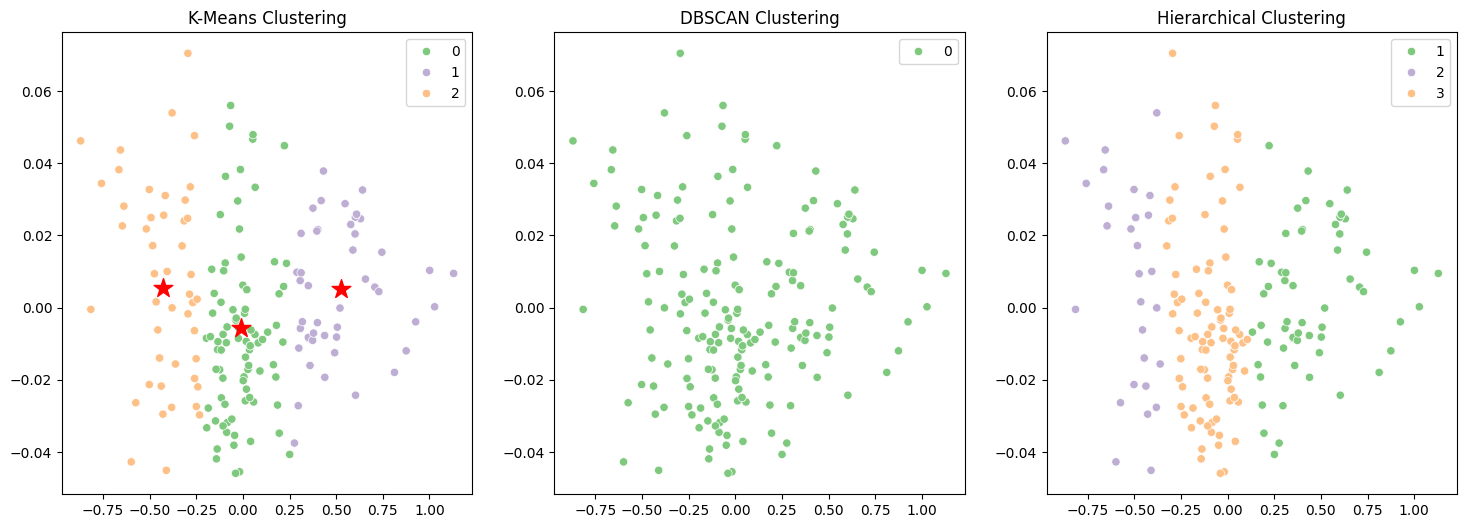

Kmeans:
  Silhouette Score: 0.5816901471497641
  Davies-Bouldin Index: 0.5025330216414962
  Calinski-Harabasz Index: 516.1404160510781
DBSCAN:
  Silhouette Score: -1
  Davies-Bouldin Index: -1
  Calinski-Harabasz Index: -1
Hierarchical:
  Silhouette Score: 0.567623815945625
  Davies-Bouldin Index: 0.5138355687484472
  Calinski-Harabasz Index: 442.5503498686488


In [112]:
# Select the group descriptors

selected_descriptors = [
'qed',
'SPS',
'MolWt',
'HeavyAtomMolWt',
'ExactMolWt',
'NumValenceElectrons',
'NumRadicalElectrons']

# New DataFrame with the new data

df_D = df[selected_descriptors]

# Call the function
results = clustering_pipeline(df_D)

# Print the results
for method, metrics in results.items():
    print(f"{method}:")
    print(f"  Silhouette Score: {metrics['silhouette']}")
    print(f"  Davies-Bouldin Index: {metrics['davies_bouldin']}")
    print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz']}")

### Group 3 Partial Charges

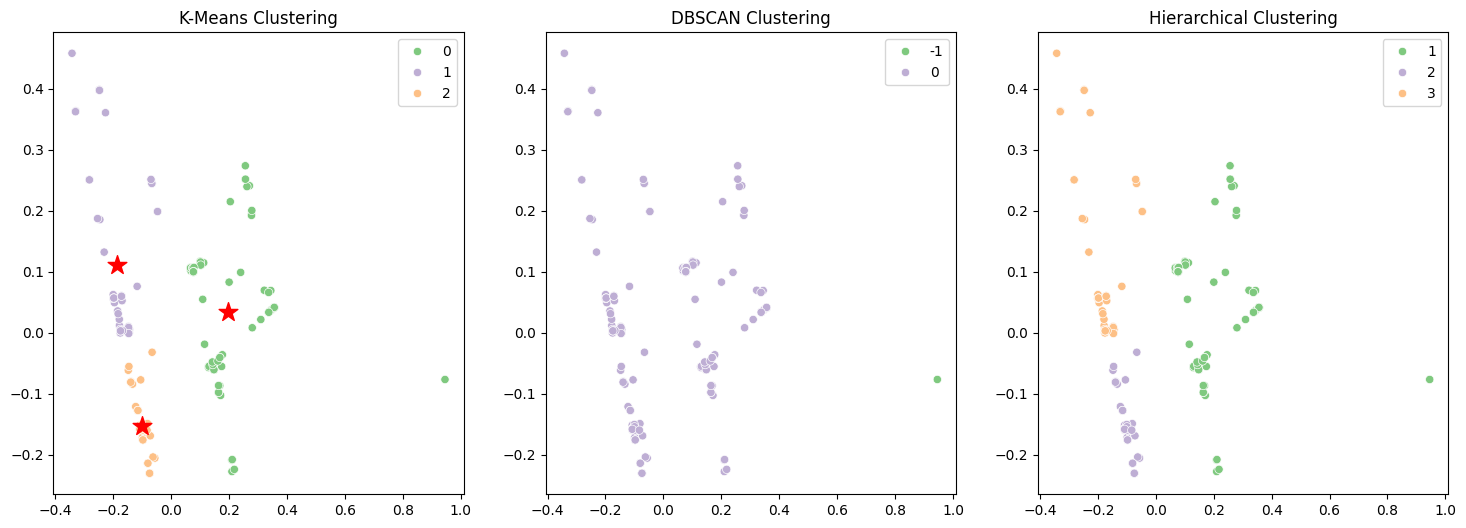

Kmeans:
  Silhouette Score: 0.5454335488114009
  Davies-Bouldin Index: 0.6474966936534767
  Calinski-Harabasz Index: 220.31188659193236
DBSCAN:
  Silhouette Score: -1
  Davies-Bouldin Index: -1
  Calinski-Harabasz Index: -1
Hierarchical:
  Silhouette Score: 0.5454335488114009
  Davies-Bouldin Index: 0.6474966936534766
  Calinski-Harabasz Index: 220.31188659193234


In [113]:
# Select the group descriptors

selected_descriptors = [
'MaxPartialCharge',
'MinPartialCharge',
'MaxAbsPartialCharge',
'MinAbsPartialCharge',
]

# New DataFrame with the new data

df_D = df[selected_descriptors]

# Call the function
results = clustering_pipeline(df_D)

# Print the results
for method, metrics in results.items():
    print(f"{method}:")
    print(f"  Silhouette Score: {metrics['silhouette']}")
    print(f"  Davies-Bouldin Index: {metrics['davies_bouldin']}")
    print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz']}")

### Group 4 Fingerprints

[21:23:04] DEPRECATION WARNING: please use MorganGenerator
[21:23:04] DEPRECATION WARNING: please use MorganGenerator
[21:23:04] DEPRECATION WARNING: please use MorganGenerator
[21:23:04] DEPRECATION WARNING: please use MorganGenerator
[21:23:04] DEPRECATION WARNING: please use MorganGenerator
[21:23:04] DEPRECATION WARNING: please use MorganGenerator
[21:23:04] DEPRECATION WARNING: please use MorganGenerator
[21:23:04] DEPRECATION WARNING: please use MorganGenerator
[21:23:04] DEPRECATION WARNING: please use MorganGenerator
[21:23:04] DEPRECATION WARNING: please use MorganGenerator
[21:23:04] DEPRECATION WARNING: please use MorganGenerator
[21:23:04] DEPRECATION WARNING: please use MorganGenerator
[21:23:04] DEPRECATION WARNING: please use MorganGenerator
[21:23:04] DEPRECATION WARNING: please use MorganGenerator
[21:23:04] DEPRECATION WARNING: please use MorganGenerator
[21:23:04] DEPRECATION WARNING: please use MorganGenerator
[21:23:04] DEPRECATION WARNING: please use MorganGenerat

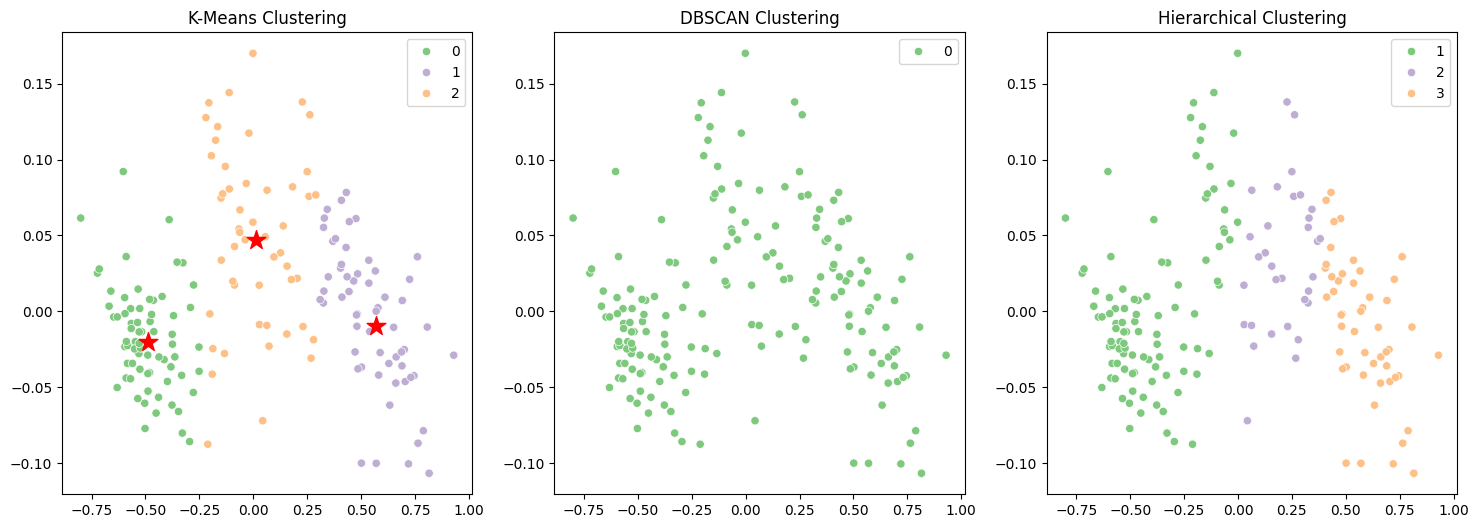

Kmeans:
  Silhouette Score: 0.6107616413131315
  Davies-Bouldin Index: 0.5207617910990772
  Calinski-Harabasz Index: 968.7177644422633
DBSCAN:
  Silhouette Score: -1
  Davies-Bouldin Index: -1
  Calinski-Harabasz Index: -1
Hierarchical:
  Silhouette Score: 0.5419406642892447
  Davies-Bouldin Index: 0.5542101267429342
  Calinski-Harabasz Index: 694.5463443673667


In [114]:
# Select the group descriptors

selected_descriptors = [
'FpDensityMorgan1',
'FpDensityMorgan2',
'FpDensityMorgan3',
]

# New DataFrame with the new data

smiles_list = database['curated_SMILES'].tolist()
delta_G = database['min deltaG '].tolist()

df_D = pd.DataFrame(columns=['SMILES', 'delta_G'] + selected_descriptors)

for i, smiles in enumerate(smiles_list):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        descriptor_values = [Descriptors.__dict__[desc](mol) for desc in selected_descriptors]
        df_D.loc[len(df_D)] = [smiles, delta_G[i]] + descriptor_values

# Call the function
results = clustering_pipeline(df_D)

# Print the results
for method, metrics in results.items():
    print(f"{method}:")
    print(f"  Silhouette Score: {metrics['silhouette']}")
    print(f"  Davies-Bouldin Index: {metrics['davies_bouldin']}")
    print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz']}")

### Group 5 BCUT Descriptors

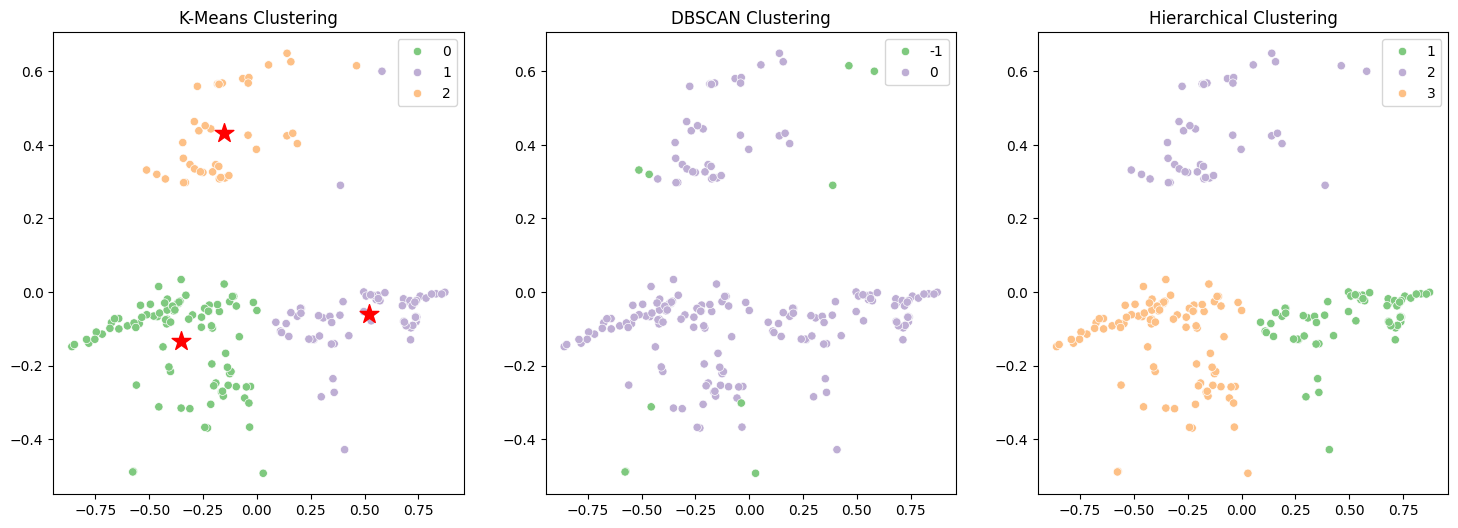

Kmeans:
  Silhouette Score: 0.4641684753604349
  Davies-Bouldin Index: 0.8874548904575486
  Calinski-Harabasz Index: 196.6958389289659
DBSCAN:
  Silhouette Score: -1
  Davies-Bouldin Index: -1
  Calinski-Harabasz Index: -1
Hierarchical:
  Silhouette Score: 0.46533139559044895
  Davies-Bouldin Index: 0.9034060761738679
  Calinski-Harabasz Index: 194.01424582964418


In [115]:
# Select the group descriptors

selected_descriptors = [
'BCUT2D_MWHI',
'BCUT2D_MWLOW',
'BCUT2D_CHGHI',
'BCUT2D_CHGLO',
'BCUT2D_LOGPHI',
'BCUT2D_LOGPLOW',
'BCUT2D_MRHI',
'BCUT2D_MRLOW',
]

# New DataFrame with the new data

df_D = df[selected_descriptors]

# Call the function
results = clustering_pipeline(df_D)

# Print the results
for method, metrics in results.items():
    print(f"{method}:")
    print(f"  Silhouette Score: {metrics['silhouette']}")
    print(f"  Davies-Bouldin Index: {metrics['davies_bouldin']}")
    print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz']}")

### Group 6 Topological Descriptors

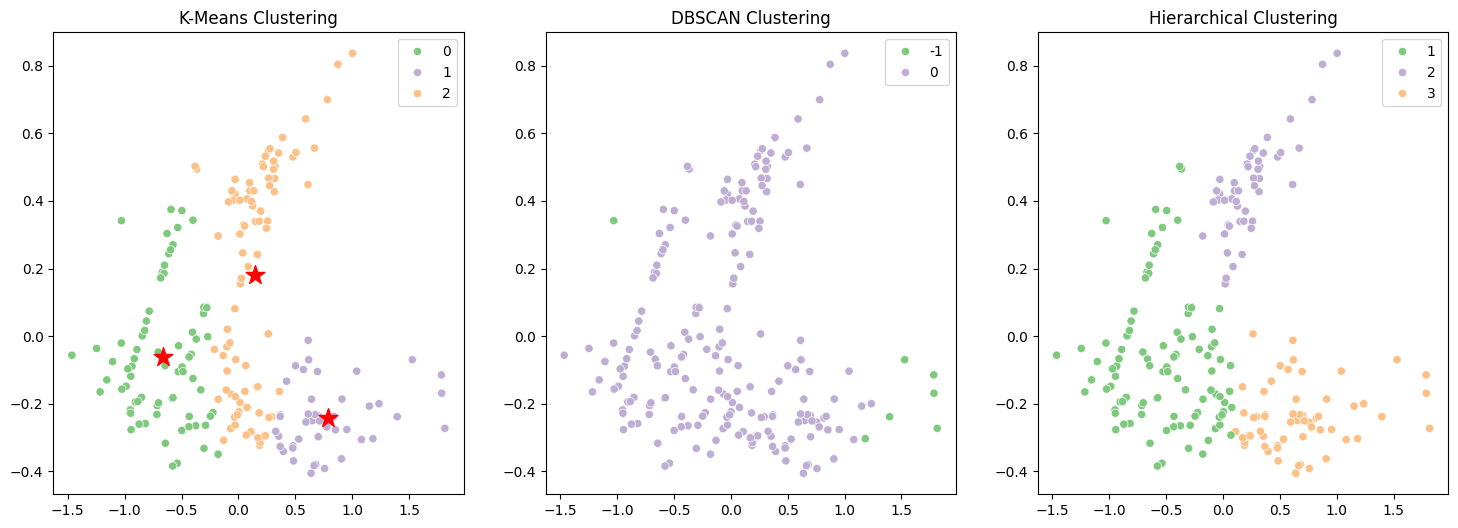

Kmeans:
  Silhouette Score: 0.39699939703013576
  Davies-Bouldin Index: 0.9415336873131542
  Calinski-Harabasz Index: 206.7804843168625
DBSCAN:
  Silhouette Score: -1
  Davies-Bouldin Index: -1
  Calinski-Harabasz Index: -1
Hierarchical:
  Silhouette Score: 0.4414392603472209
  Davies-Bouldin Index: 0.7535381577049075
  Calinski-Harabasz Index: 200.3775165397681


In [116]:
# Select the group descriptors
selected_descriptors = [
'AvgIpc',
'BalabanJ',
'BertzCT',
'Chi0',
'Chi0n',
'Chi0v',
'Chi1',
'Chi1n',
'Chi1v',
'Chi2n',
'Chi2v',
'Chi3n',
'Chi3v',
'Chi4n',
'Chi4v',
]

# New DataFrame with the new data

df_D = df[selected_descriptors]

# Call the function
results = clustering_pipeline(df_D)

# Print the results
for method, metrics in results.items():
    print(f"{method}:")
    print(f"  Silhouette Score: {metrics['silhouette']}")
    print(f"  Davies-Bouldin Index: {metrics['davies_bouldin']}")
    print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz']}")

### Group 7 Shape Descriptors

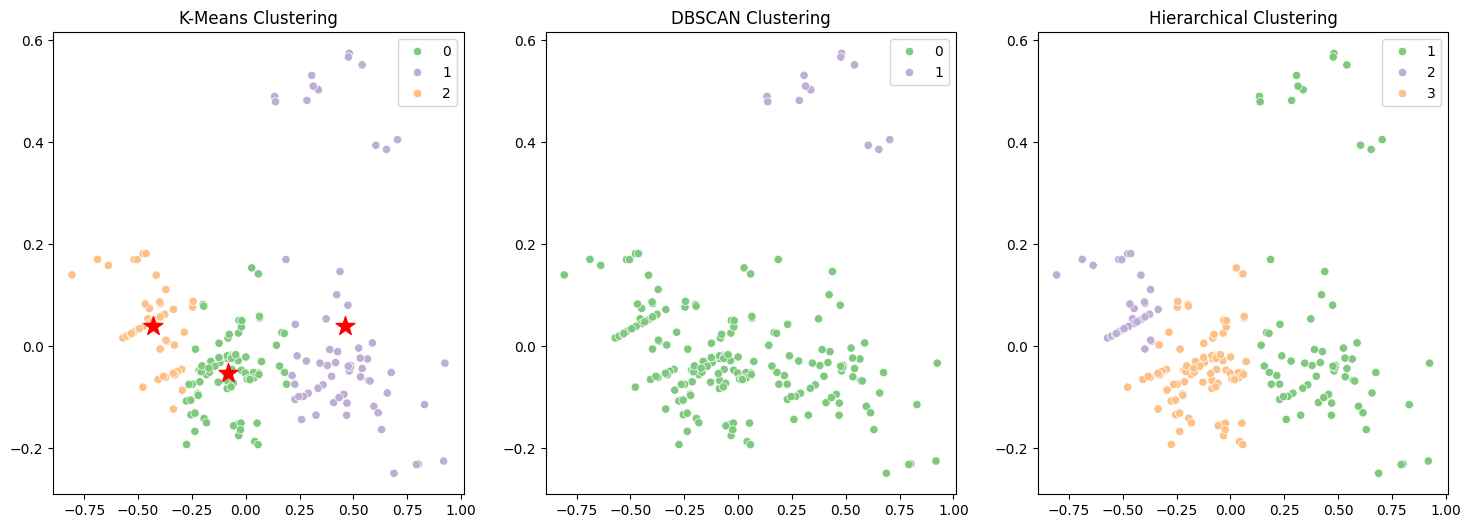

Kmeans:
  Silhouette Score: 0.44979846153800784
  Davies-Bouldin Index: 0.7042088924013733
  Calinski-Harabasz Index: 282.6999260355806
DBSCAN:
  Silhouette Score: 0.42069142660046205
  Davies-Bouldin Index: 0.8124439807119481
  Calinski-Harabasz Index: 37.91871796784534
Hierarchical:
  Silhouette Score: 0.44608909506434796
  Davies-Bouldin Index: 0.6779009660422024
  Calinski-Harabasz Index: 265.69210347770684


In [117]:
# Select the group descriptors
selected_descriptors = [
'HallKierAlpha',
'Ipc',
'Kappa1',
'Kappa2',
'Kappa3',
'LabuteASA',
]

# New DataFrame with the new data

df_D = df[selected_descriptors]

# Call the function
results = clustering_pipeline(df_D)

# Print the results
for method, metrics in results.items():
    print(f"{method}:")
    print(f"  Silhouette Score: {metrics['silhouette']}")
    print(f"  Davies-Bouldin Index: {metrics['davies_bouldin']}")
    print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz']}")

### Group 8 PEOE VSA Descriptors

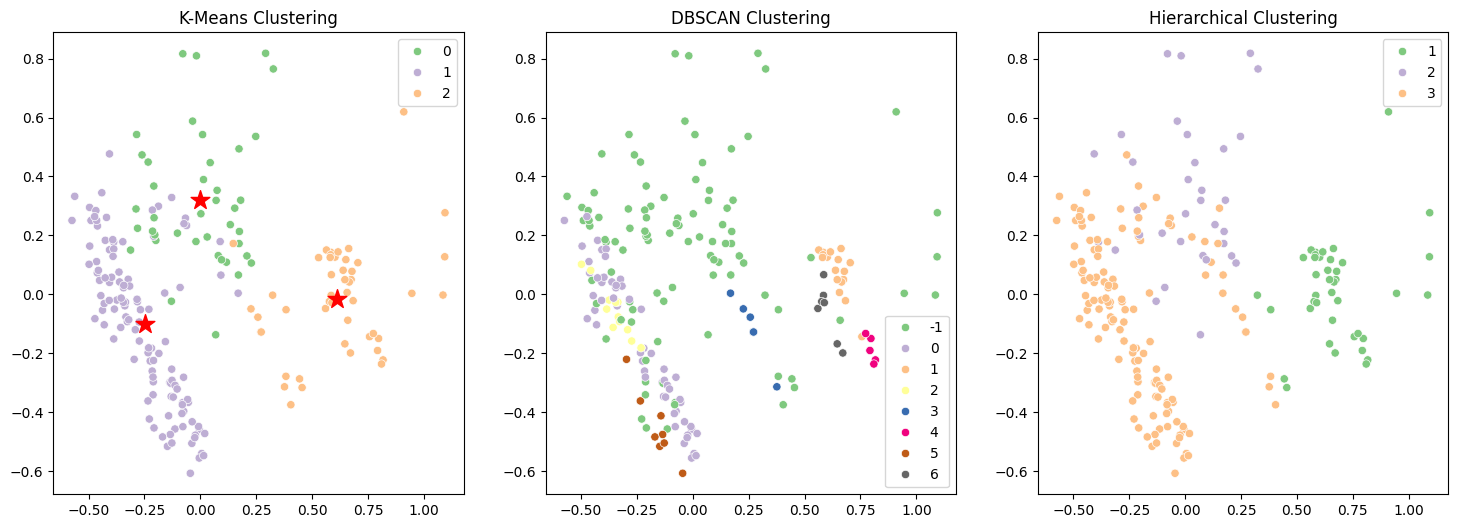

Kmeans:
  Silhouette Score: 0.2617927351841222
  Davies-Bouldin Index: 1.786588567450902
  Calinski-Harabasz Index: 52.35915354364193
DBSCAN:
  Silhouette Score: 0.24074744931907127
  Davies-Bouldin Index: 1.061120788178895
  Calinski-Harabasz Index: 31.254515017293002
Hierarchical:
  Silhouette Score: 0.26697727383637554
  Davies-Bouldin Index: 1.7967817241501933
  Calinski-Harabasz Index: 49.05022349489318


In [118]:
# Select the group descriptors
selected_descriptors = [
'PEOE_VSA1',
'PEOE_VSA10',
'PEOE_VSA11',
'PEOE_VSA12',
'PEOE_VSA13',
'PEOE_VSA14',
'PEOE_VSA2',
'PEOE_VSA3',
'PEOE_VSA4',
'PEOE_VSA5',
'PEOE_VSA6',
'PEOE_VSA7',
'PEOE_VSA8',
'PEOE_VSA9',
]

# New DataFrame with the selected columns

df_D = df[selected_descriptors]

# Call the function
results = clustering_pipeline(df_D)

# Print the results
for method, metrics in results.items():
    print(f"{method}:")
    print(f"  Silhouette Score: {metrics['silhouette']}")
    print(f"  Davies-Bouldin Index: {metrics['davies_bouldin']}")
    print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz']}")

### Group 9 SMR VSA

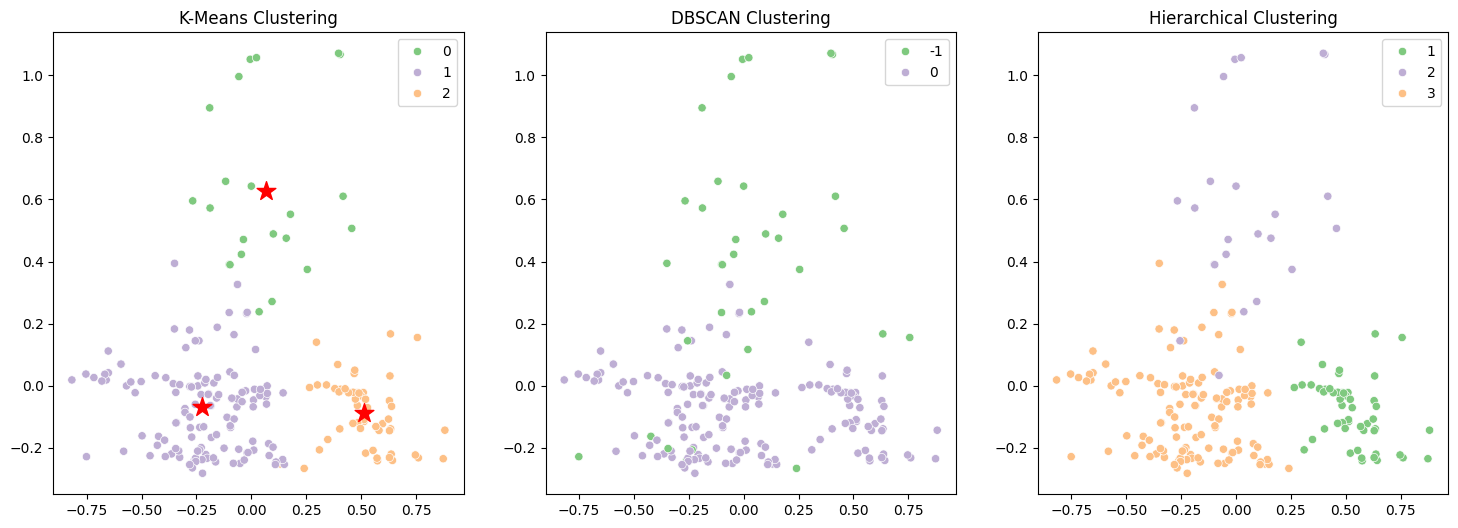

Kmeans:
  Silhouette Score: 0.3558770258578769
  Davies-Bouldin Index: 1.1138258174743132
  Calinski-Harabasz Index: 84.7985847970275
DBSCAN:
  Silhouette Score: -1
  Davies-Bouldin Index: -1
  Calinski-Harabasz Index: -1
Hierarchical:
  Silhouette Score: 0.35258985175633883
  Davies-Bouldin Index: 1.1488796577271294
  Calinski-Harabasz Index: 83.07343644175893


In [119]:
# Select the group descriptors
selected_descriptors = [
'SMR_VSA1',
'SMR_VSA10',
'SMR_VSA2',
'SMR_VSA3',
'SMR_VSA4',
'SMR_VSA5',
'SMR_VSA6',
'SMR_VSA7',
'SMR_VSA8',
'SMR_VSA9',
]

# New DataFrame with the selected columns

df_D = df[selected_descriptors]

# Call the function
results = clustering_pipeline(df_D)

# Print the results
for method, metrics in results.items():
    print(f"{method}:")
    print(f"  Silhouette Score: {metrics['silhouette']}")
    print(f"  Davies-Bouldin Index: {metrics['davies_bouldin']}")
    print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz']}")

### Group 10 SlogP VSA Descriptors

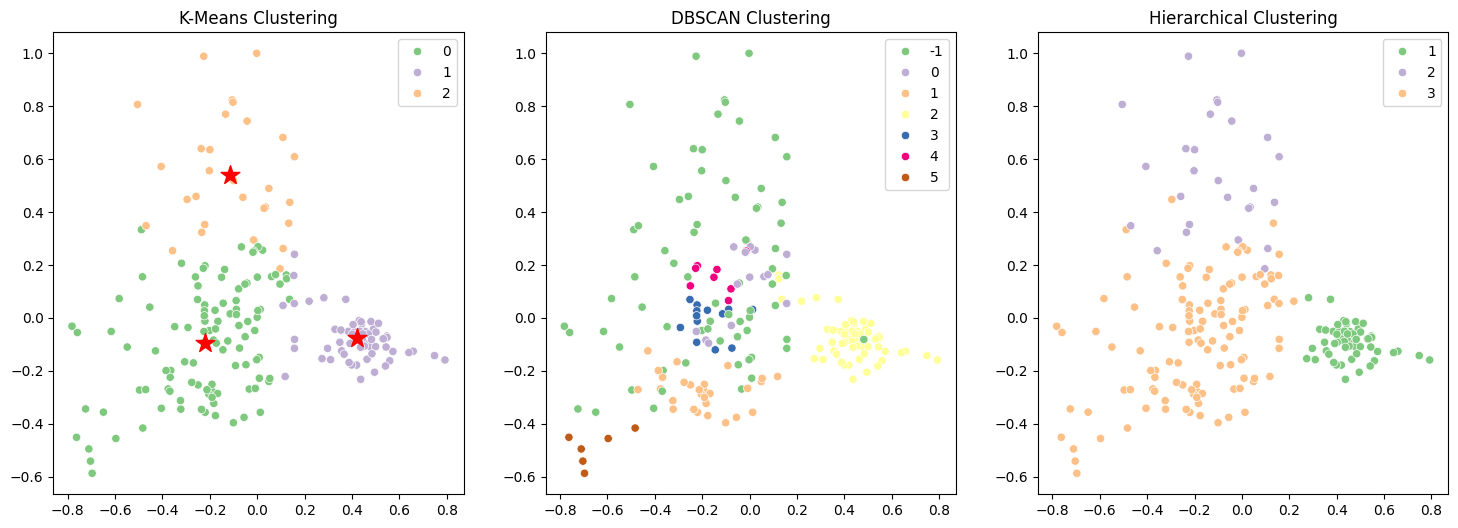

Kmeans:
  Silhouette Score: 0.2812122742091922
  Davies-Bouldin Index: 1.3663546477779647
  Calinski-Harabasz Index: 64.84903738451074
DBSCAN:
  Silhouette Score: 0.40382058076615673
  Davies-Bouldin Index: 1.0276945755085578
  Calinski-Harabasz Index: 57.64721089118381
Hierarchical:
  Silhouette Score: 0.27653018568260984
  Davies-Bouldin Index: 1.3546967047911274
  Calinski-Harabasz Index: 62.96577201420699


In [120]:
# Select the group descriptors
selected_descriptors =[
'SlogP_VSA1',
'SlogP_VSA10',
'SlogP_VSA11',
'SlogP_VSA12',
'SlogP_VSA2',
'SlogP_VSA3',
'SlogP_VSA4',
'SlogP_VSA5',
'SlogP_VSA6',
'SlogP_VSA7',
'SlogP_VSA8',
'SlogP_VSA9',
]

# New DataFrame with the selected columns

df_D = df[selected_descriptors]

# Call the function
results = clustering_pipeline(df_D)

# Print the results
for method, metrics in results.items():
    print(f"{method}:")
    print(f"  Silhouette Score: {metrics['silhouette']}")
    print(f"  Davies-Bouldin Index: {metrics['davies_bouldin']}")
    print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz']}")

### Group 11 EState VSA Descriptors

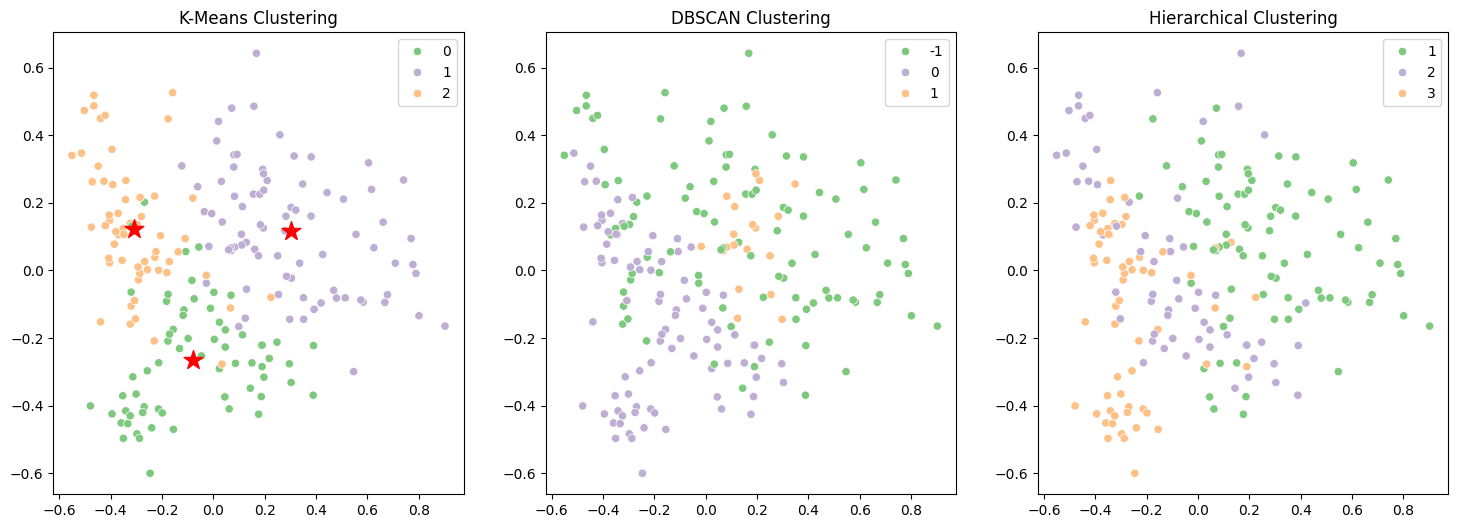

Kmeans:
  Silhouette Score: 0.19600925679973746
  Davies-Bouldin Index: 1.6488242673112152
  Calinski-Harabasz Index: 47.127667078682656
DBSCAN:
  Silhouette Score: 0.239655150943534
  Davies-Bouldin Index: 1.249639126845271
  Calinski-Harabasz Index: 25.707857382395005
Hierarchical:
  Silhouette Score: 0.15659409848777955
  Davies-Bouldin Index: 1.9623403017325307
  Calinski-Harabasz Index: 37.20897916800094


In [121]:
# Select the group descriptors

selected_descriptors =[
'EState_VSA1',
'EState_VSA10',
'EState_VSA11',
'EState_VSA2',
'EState_VSA3',
'EState_VSA4',
'EState_VSA5',
'EState_VSA6',
'EState_VSA7',
'EState_VSA8',
'EState_VSA9'
]

# New DataFrame with the selected columns

df_D = df[selected_descriptors]

# Call the function
results = clustering_pipeline(df_D)

# Print the results
for method, metrics in results.items():
    print(f"{method}:")
    print(f"  Silhouette Score: {metrics['silhouette']}")
    print(f"  Davies-Bouldin Index: {metrics['davies_bouldin']}")
    print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz']}")

### Group 12 VSA EState Descriptors

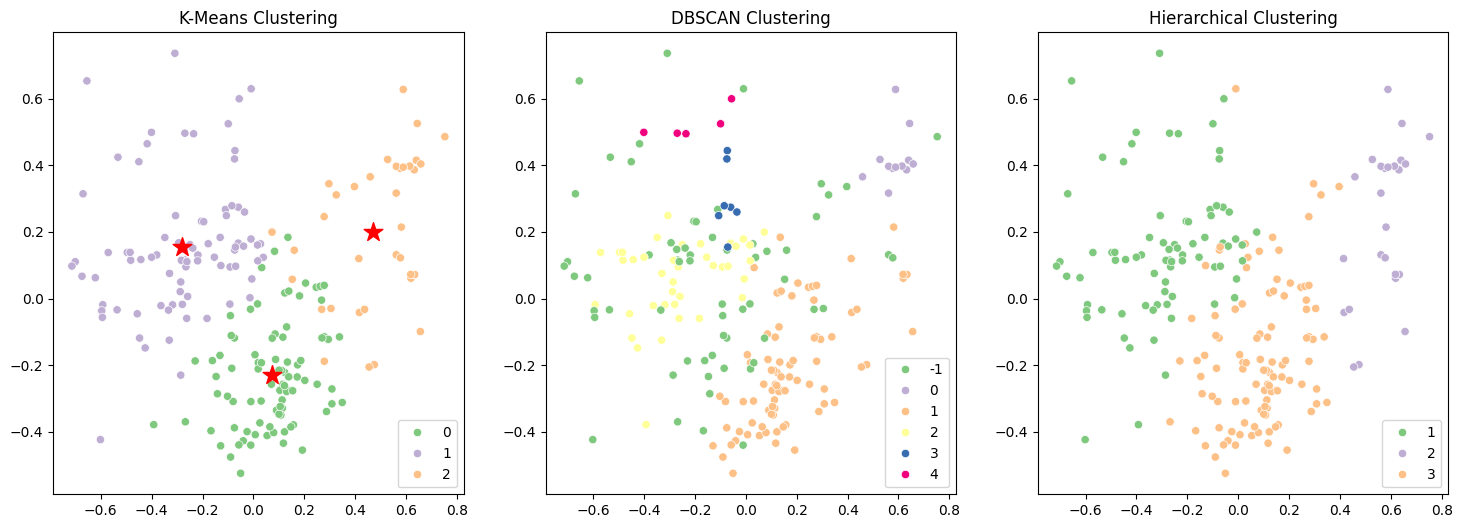

Kmeans:
  Silhouette Score: 0.2369282851160676
  Davies-Bouldin Index: 1.5260025706153193
  Calinski-Harabasz Index: 56.74010346530301
DBSCAN:
  Silhouette Score: 0.31221851517790583
  Davies-Bouldin Index: 0.9506899250044125
  Calinski-Harabasz Index: 38.3779195765165
Hierarchical:
  Silhouette Score: 0.21695286427923918
  Davies-Bouldin Index: 1.6034289325698348
  Calinski-Harabasz Index: 49.878605400128905


In [122]:
# Select the group descriptors

selected_descriptors =[
'VSA_EState1',
'VSA_EState10',
'VSA_EState2',
'VSA_EState3',
'VSA_EState4',
'VSA_EState5',
'VSA_EState6',
'VSA_EState7',
'VSA_EState8',
'VSA_EState9'
]

# New DataFrame with the selected columns

df_D = df[selected_descriptors]

# Call the function
results = clustering_pipeline(df_D)

# Print the results
for method, metrics in results.items():
    print(f"{method}:")
    print(f"  Silhouette Score: {metrics['silhouette']}")
    print(f"  Davies-Bouldin Index: {metrics['davies_bouldin']}")
    print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz']}")

### Group 13 Simple Molecular Properties

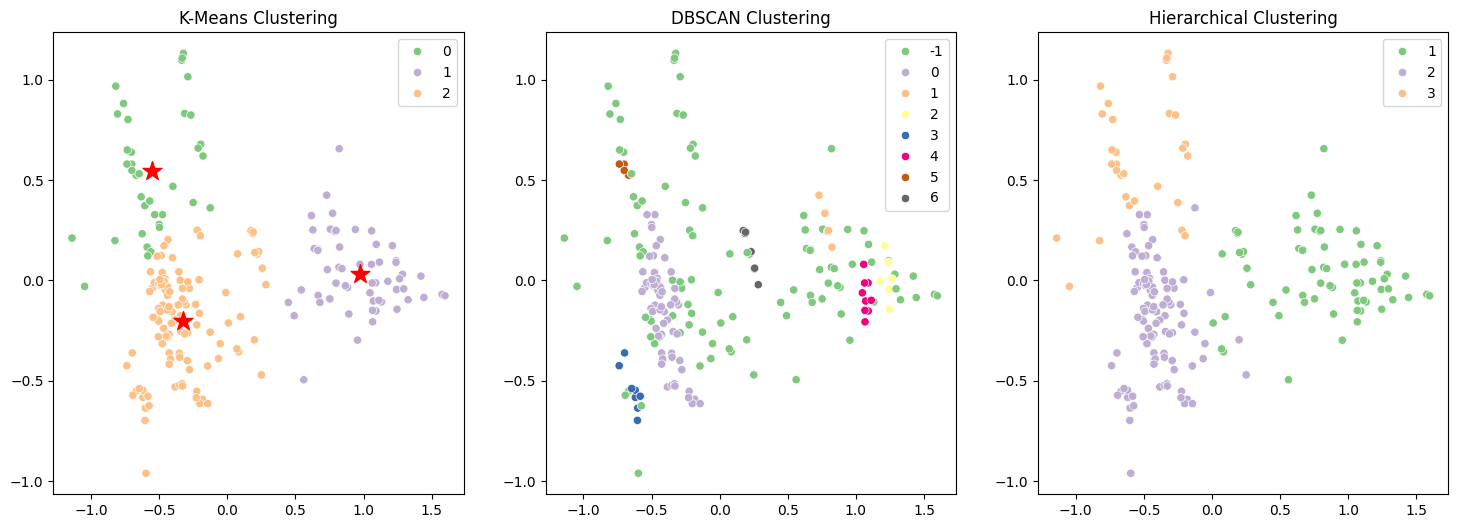

Kmeans:
  Silhouette Score: 0.3157404630857741
  Davies-Bouldin Index: 1.3772306740545905
  Calinski-Harabasz Index: 106.42875375327584
DBSCAN:
  Silhouette Score: 0.3565732428398152
  Davies-Bouldin Index: 0.7357709249269107
  Calinski-Harabasz Index: 62.66070386964103
Hierarchical:
  Silhouette Score: 0.32545916965171356
  Davies-Bouldin Index: 1.3835019531804456
  Calinski-Harabasz Index: 97.49727538608417


In [123]:
# Select the group descriptors

selected_descriptors =[
'FractionCSP3',
'HeavyAtomCount',
'NHOHCount',
'NOCount',
'NumAliphaticCarbocycles',
'NumAliphaticHeterocycles',
'NumAliphaticRings',
'NumAromaticCarbocycles',
'NumAromaticHeterocycles',
'NumAromaticRings',
'NumHAcceptors',
'NumHDonors',
'NumHeteroatoms',
'NumRotatableBonds',
'NumSaturatedCarbocycles',
'NumSaturatedHeterocycles',
'NumSaturatedRings',
'RingCount',
'MolLogP',
'MolMR',
]

# New DataFrame with the selected columns

df_D = df[selected_descriptors]

# Call the function
results = clustering_pipeline(df_D)

# Print the results
for method, metrics in results.items():
    print(f"{method}:")
    print(f"  Silhouette Score: {metrics['silhouette']}")
    print(f"  Davies-Bouldin Index: {metrics['davies_bouldin']}")
    print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz']}")

### Group 14 Functional Group Descriptors

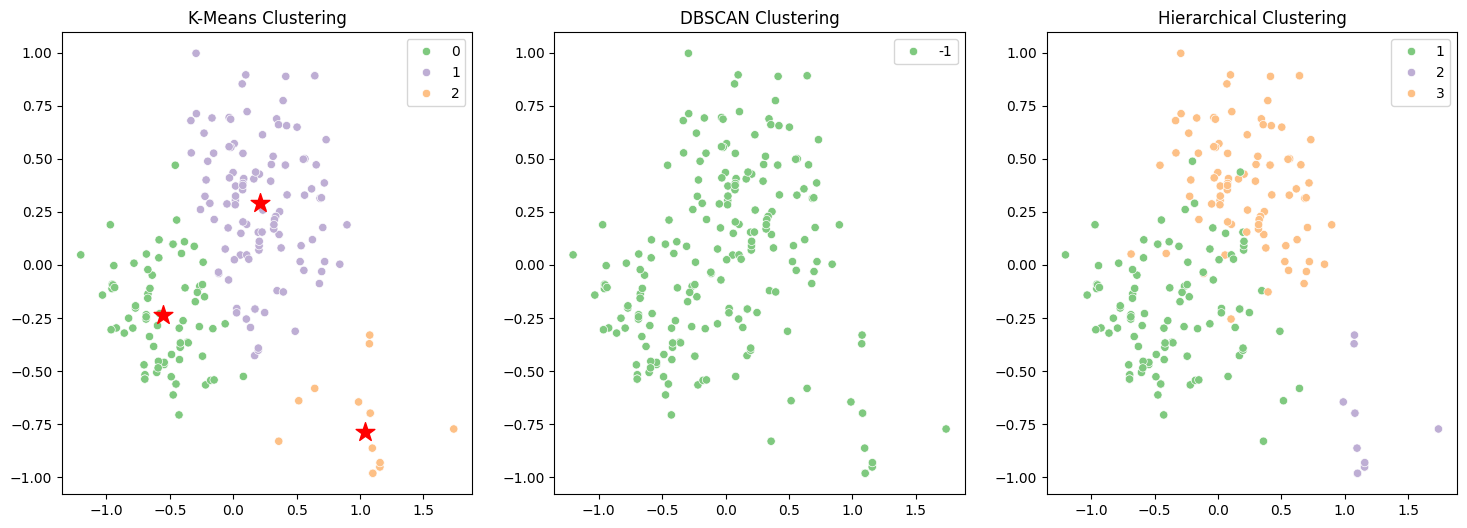

Kmeans:
  Silhouette Score: 0.1883327386095691
  Davies-Bouldin Index: 1.7644617146485306
  Calinski-Harabasz Index: 36.810265067402796
DBSCAN:
  Silhouette Score: -1
  Davies-Bouldin Index: -1
  Calinski-Harabasz Index: -1
Hierarchical:
  Silhouette Score: 0.18086010105373118
  Davies-Bouldin Index: 1.8661926906961488
  Calinski-Harabasz Index: 33.14861996149694


In [124]:
# Select the group descriptors

selected_descriptors = [
    'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH',
    'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2',
    'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH',
    'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline',
    'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine',
    'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone', 'fr_imidazole',
    'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy',
    'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation',
    'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine',
    'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
    'fr_unbrch_alkane', 'fr_urea'
]

# New DataFrame with the selected columns

df_D = df[selected_descriptors]

# Call the function
results = clustering_pipeline(df_D)

# Print the results
for method, metrics in results.items():
    print(f"{method}:")
    print(f"  Silhouette Score: {metrics['silhouette']}")
    print(f"  Davies-Bouldin Index: {metrics['davies_bouldin']}")
    print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz']}")

Último grupo, con las columnas utilizadas para los algoritmos de ML supervisado

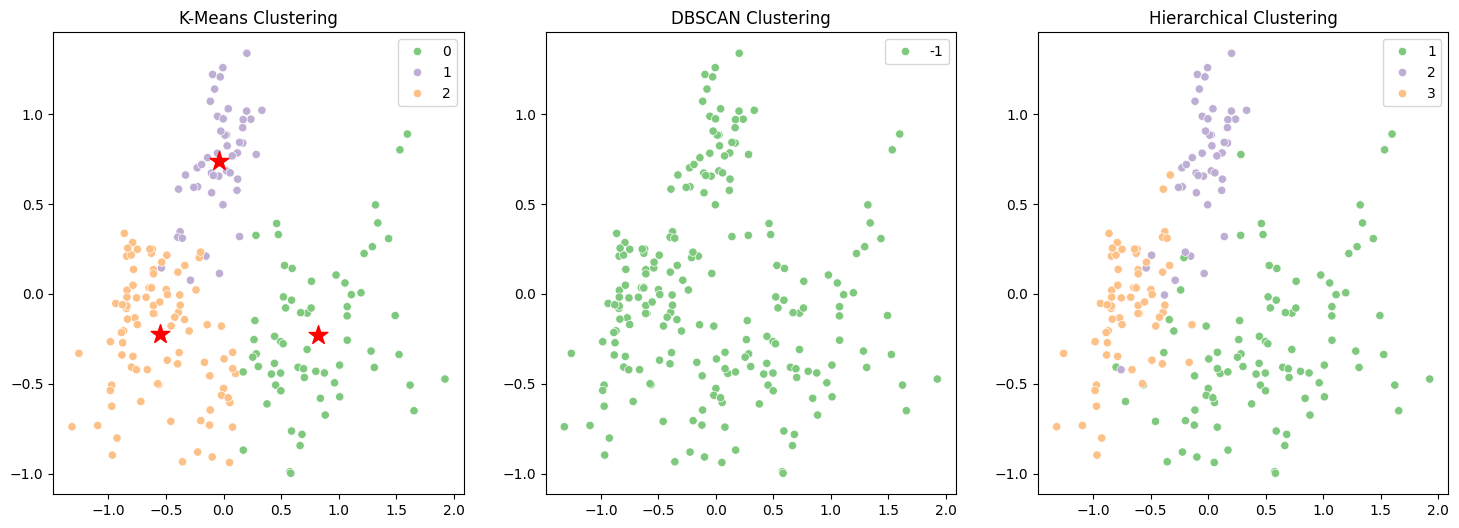

Kmeans:
  Silhouette Score: 0.18081924884517533
  Davies-Bouldin Index: 1.6694482778086714
  Calinski-Harabasz Index: 44.45329670637343
DBSCAN:
  Silhouette Score: -1
  Davies-Bouldin Index: -1
  Calinski-Harabasz Index: -1
Hierarchical:
  Silhouette Score: 0.1486302112881403
  Davies-Bouldin Index: 1.8020491375149994
  Calinski-Harabasz Index: 36.81801954933429


In [125]:
# Select the group descriptors

# Selected descriptors list
selected_descriptors = [
    'MolWt', 'MolLogP', 'TPSA', 'NumHAcceptors', 'NumHDonors',
    'HeavyAtomCount', 'FractionCSP3', 'BalabanJ', 'BertzCT',
    'Kappa1', 'Kappa2', 'Kappa3', 'Chi0v', 'Chi1v', 'Chi2v',
    'LabuteASA', 'EState_VSA1', 'EState_VSA2', 'EState_VSA3',
    'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7',
    'EState_VSA8', 'EState_VSA9', 'EState_VSA10', 'EState_VSA11',
    'PEOE_VSA1', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5',
    'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'PEOE_VSA10',
    'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14',
    'NumRotatableBonds', 'RingCount'
]

# New DataFrame with the selected columns

df_D = df[selected_descriptors]

# Call the function
results = clustering_pipeline(df_D)

# Print the results
for method, metrics in results.items():
    print(f"{method}:")
    print(f"  Silhouette Score: {metrics['silhouette']}")
    print(f"  Davies-Bouldin Index: {metrics['davies_bouldin']}")
    print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz']}")

### Resultados

Los algoritmos de clustering no muestran unos grandes resultados tanto para el resultado de todas las columnas, como para los subgrupos de descriptores moleculares o los subgrupos de trabajo. Los resultados no son óptimos, por lo general Kmans y cluster jerárquico forman clústeres, pero sus métricas siguen teniendo un mal desempeño.


# 6. Model Performance (metrics) <a name="desempeno-del-modelo-metricas"></a>

In [126]:
#X_train_pca.shape, X_test_pca.shape, y_train.shape, y_test.shape

In [127]:
# Mostrar los resultados
#print(results['models'])
#print(results['predictions'])


In [128]:
models

Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RidgeCV                                      0.60       0.68  0.45        0.02
LassoLarsIC                                  0.60       0.68  0.46        0.02
Ridge                                        0.60       0.68  0.46        0.02
Lars                                         0.60       0.68  0.46        0.05
TransformedTargetRegressor                   0.60       0.68  0.46        0.02
LinearRegression                             0.60       0.68  0.46        0.01
BayesianRidge                                0.60       0.68  0.46        0.02
SGDRegressor                                 0.60       0.68  0.46        0.02
HuberRegressor                               0.60       0.68  0.46        0.03
LinearSVR                                    0.59       0.67  0.46        0.02
ElasticNetCV                                 0.58       0.66  0.47        0.07
OrthogonalMatchingPursuitCV                  0.57       0.66  0.47        0.04
LarsCV                                       0.57       0.65  0.47        0.07
LassoLarsCV                                  0.57       0.65  0.47        0.04
LassoCV                                      0.57       0.65  0.47        0.10
ExtraTreesRegressor                          0.55       0.64  0.48        0.19
AdaBoostRegressor                            0.55       0.63  0.49        0.13
GradientBoostingRegressor                    0.52       0.61  0.50        0.29
RandomForestRegressor                        0.50       0.60  0.51        0.47
LGBMRegressor                                0.50       0.60  0.51        0.15
SVR                                          0.50       0.59  0.51        0.02
NuSVR                                        0.49       0.59  0.51        0.04
HistGradientBoostingRegressor                0.48       0.58  0.52        0.24
KNeighborsRegressor                          0.46       0.56  0.53        0.03
BaggingRegressor                             0.44       0.55  0.54        0.05
XGBRegressor                                 0.44       0.54  0.54        1.89
OrthogonalMatchingPursuit                    0.42       0.53  0.55        0.03
TweedieRegressor                             0.39       0.51  0.56        0.09
ExtraTreeRegressor                           0.35       0.48  0.58        0.01
PassiveAggressiveRegressor                   0.17       0.33  0.66        0.01
DecisionTreeRegressor                        0.15       0.31  0.66        0.02
ElasticNet                                  -0.12       0.10  0.76        0.02
DummyRegressor                              -0.25      -0.01  0.81        0.02
LassoLars                                   -0.25      -0.01  0.81        0.02
Lasso                                       -0.25      -0.01  0.81        0.01
RANSACRegressor                             -0.28      -0.03  0.81        0.29
MLPRegressor                                -3.22      -2.41  1.48        0.87
GaussianProcessRegressor                  -104.73     -84.31  7.41        0.03
KernelRidge                               -177.52    -143.04  9.62        0.04

# 7. Validation Methods <a name="metodos-de-validacion"></a>

# 8. Tuning <a name="tuning"></a>

# 9. Results and Conclusions <a name="resultados-y-conclusiones"></a>

**Importancia de la Precisión en las Previsiones:** La precisión de las previsiones es un aspecto fundamental. Contar con predicciones exactas puede influir notablemente en los procesos de toma de decisiones, y, en última instancia, determinar el éxito o el fracaso de un proyecto.

**Error Absoluto Medio (MAE**):  El **error absoluto medio (MAE**) es una métrica comúnmente utilizada para medir la precisión de los modelos de pronóstico. Ofrece una forma sencilla e intuitiva de cuantificar la magnitud promedio de los errores en un conjunto de predicciones. **MAE** mide los errores absolutos, lo que implica que no considera la dirección de los errores. Esto puede ser una ventaja, ya que trata las sobreestimaciones y subestimaciones por igual, siendo útil cuando la magnitud de los errores es más importante que su dirección. Sin embargo, **MAE** depende de la escala de los datos analizados, por lo que es esencial considerar el contexto y las unidades de medida al interpretar sus valores. Cuanto menor sea el **MAE**, mejor será la capacidad predictiva del modelo en términos de la diferencia absoluta entre las predicciones y los valores reales observados.

**Error Cuadrático Medio (MSE):** El **error cuadrático Medio (MSE**) se utiliza para cuantificar la diferencia entre los valores predichos por un modelo y los valores realmente observados. Se calcula promediando el cuadrado de las diferencias entre cada valor predicho y el valor real, lo que penaliza más los errores grandes. Esta característica es crucial en situaciones donde los errores grandes son más significativos que los pequeños. La importancia del **MSE** radica en su capacidad para proporcionar una medida clara y concisa de la precisión del modelo. Un buen modelo tendrá un **MSE** bajo, por lo que minimizar el MSE durante el entrenamiento mejora eficazmente la precisión predictiva del modelo.

**Raíz del Error Cuadrático Medio (RMSE)**: La raíz del error cuadrático medio (**RMSE**) es otra métrica popular para medir la precisión del pronóstico. A diferencia del **MAE**, el **RMSE** considera el cuadrado de los errores, lo que otorga más peso a los errores mayores. Esto es útil cuando se desea penalizar más los errores significativos, aunque también significa que el **RMSE** puede verse afectado por valores extremos y sesgado por valores atípicos. En general, un **RMSE** más bajo indica una mejor capacidad predictiva del modelo en términos de la diferencia cuadrática media entre las predicciones y los valores reales observados.

**Coeficiente de Determinación (R-cuadrado):** El **coeficiente de determinación, R-cuadrado**, indica qué tan bien se ajusta el modelo a los datos, pero no garantiza que el modelo sea correcto o significativo. Un **R-cuadrado** alto no siempre implica un buen modelo, y un **R-cuadrado** bajo no necesariamente indica un mal modelo. Es importante considerar varios factores al interpretar **R-cuadrado**. Por ejemplo, agregar más variables al modelo siempre aumentará o mantendrá **R-cuadrado**, incluso si son irrelevantes o redundantes, lo que puede llevar al sobreajuste. Para evitar esto, se puede usar el **R-cuadrado** ajustado, que penaliza al modelo por tener demasiadas variables y ajusta **R-cuadrado** según los grados de libertad. Además, **R-cuadrado** no indica causalidad ni direccionalidad, solo mide la fuerza de la relación lineal entre las variables.

Los modelos evaluados en términos de sus métricas de rendimiento (**MAE, MSE, RMSE, R2**) muestran que tanto  **Random Forest**, **Support Vector Machine (SVM)**, y **Gradient Boosting Machine** son capaces de capturar y predecir patrones en los datos con cierto grado de precisión.

**Random Forest** y **Support Vector Machine (SVM**) muestran un rendimiento bastante similar en términos de R2, con ambos modelos explicando aproximadamente el 60% de la varianza en los datos de salida. Sin embargo, **SVM** exhibe un ligero beneficio con un **MAE** ligeramente inferior y un **MSE** ligeramente superior en comparación con **Random Forest.** Este resultado sugiere que **SVM** tiende a cometer menos errores en términos de la magnitud de las predicciones absolutas.

Por otro lado, **Gradient Boosting Machine** también muestra un rendimiento competitivo, aunque ligeramente inferior en comparación con los otros dos modelos. Aunque aún es capaz de capturar la mayoría de la variabilidad en los datos, los valores ligeramente más altos de **MAE** y **RMSE** indican que las predicciones pueden ser un poco menos precisas en comparación con **Random Forest** y **SVM**.

En resumen, **Support Vector Machine (SVM**) es la opción más viable con un buen equilibrio entre precisión y capacidad predictiva.

## Autores:

- Diego Javier Monterrubio Chanca
- Andrés Sepulveda Nascimento
- Patricia Torres
- María Aguado González